<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Filter-data-to-remove-windows-with-poor-quality-waveforms" data-toc-modified-id="Filter-data-to-remove-windows-with-poor-quality-waveforms-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Filter data to remove windows with poor quality waveforms</a></span></li><li><span><a href="#Remove-windows-that-are-too-far-from-cuff,-and-use-time-from-cuff-to-weight-samples" data-toc-modified-id="Remove-windows-that-are-too-far-from-cuff,-and-use-time-from-cuff-to-weight-samples-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Remove windows that are too far from cuff, and use time from cuff to weight samples</a></span></li><li><span><a href="#Create-training-matrix" data-toc-modified-id="Create-training-matrix-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create training matrix</a></span></li><li><span><a href="#PPG-Scaling" data-toc-modified-id="PPG-Scaling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>PPG Scaling</a></span><ul class="toc-item"><li><span><a href="#Create-one-hot-vector-for-systolic/diastolic-points" data-toc-modified-id="Create-one-hot-vector-for-systolic/diastolic-points-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Create one-hot vector for systolic/diastolic points</a></span></li></ul></li><li><span><a href="#Create-ABP-model" data-toc-modified-id="Create-ABP-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Create ABP model</a></span><ul class="toc-item"><li><span><a href="#Create-joint-Bland-Altman-plot" data-toc-modified-id="Create-joint-Bland-Altman-plot-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Create joint Bland-Altman plot</a></span></li></ul></li></ul></div>

In [1]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp

from tqdm import tqdm
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

#sys.path.append("../")
import project_configs_simon as project_configs
import src.models.abp_model as abp_model
from src.models.abp_model import batch_custom_loss
import src.utils as utils
from src.utils import *

2022-08-02 15:37:06.463686: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-02 15:37:06.463775: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # GPU ID

In [43]:
np.random.seed(12)
train_or_test = "test"
train_or_test_bp_summary = "test"
bp_model_name = "bp_model_4s"
save_model = False
load_model = True
model_type = "vnet"
# NOTE: for sideris model, residual_or_raw should be set to raw
residual_or_raw = "residual"
model_name = "vnet_32s_mimicsimon"

In [6]:
project_configs.dataset = 'mimic'

if project_configs.dataset == "mimic":
    matrix_dir = "/data2/mimic/ABP_with_Med_data/patients/results/compare"

# Load Data

In [7]:
generate_files = False

In [8]:
ppg_qi_model_file = "/home/simonlee/models/ppg_qi_model.hdf5"
ppg_scaler_pkl_file = "/home/simonlee/models/ppg_qi_scaler.pkl"
threshold = 0.8108692169189453 # threshold determined on MIMIC validation data such that precision=0.95

def filter_ppg_qi(X, ppg_qi_model_file, ppg_scaler_pkl_file, threshold, ppg_window_size=400):

    if X.shape[0] == 0:
        return X
    
    # load PPG QI model from file
    ppg_qi = tf.keras.models.load_model(ppg_qi_model_file)

    # load PPG QI scaler object
    ppg_qi_scaler = pickle.load(open(ppg_scaler_pkl_file, "rb"))
    
    # calculate number of PPG QI windows within input window 
    # for example, if we have 32s windows, we have 8 PPG QI predictions 
    # per window/row
    num_windows = int(project_configs.window_size / ppg_window_size)
    print(num_windows)

    ppg_window_preds = []
    for i in range(num_windows):
        print(int(i*ppg_window_size), int(i*ppg_window_size + ppg_window_size))
        ppg_window_preds.append(ppg_qi.predict( np.expand_dims(ppg_qi_scaler.transform(X[:, int(i*ppg_window_size):int(i*ppg_window_size + ppg_window_size), project_configs.ppg_col]), -1) )[:, 0])

    # stack each pred, and take min across windows (rows) to get worst case PPG QI in each window
    ppg_qi_preds = np.column_stack(ppg_window_preds).min(axis=1)

    valid_window_idx = np.where(np.array(ppg_qi_preds) > threshold)
    print("{}/{} ({:.2f}%) windows are valid".format(
        len(valid_window_idx[0]), 
        len(ppg_qi_preds), 
        len(valid_window_idx[0])/len(ppg_qi_preds)*100.))

    X = X[valid_window_idx]
    
    return X

In [9]:
def filter_far_from_cuff(X, max_time_mins=5):
    # get time from cuff (proximity) in seconds
    time_from_cuff = X[:, :, project_configs.prox_col].mean(axis=1) / project_configs.sample_freq

    # find all rows where mean prox is less than threshold
    max_num_secs_from_cuff = max_time_mins*60
    valid_samples_from_cuff = time_from_cuff <= max_num_secs_from_cuff

    print("{:.1f}% of windows are valid".format(valid_samples_from_cuff.mean()*100.))

    X = X[valid_samples_from_cuff]
    return X

In [10]:
def filter_missing_NIBP(X):
    # Remove windows with no NIBP measurements

    shape_pre_filter = X.shape[0]
    X = X[np.where(np.median(X[:, :, project_configs.nibp_sys_col], axis=1) > 0)[0]]
    print("Removed {} windows with missing NIBP sys".format(shape_pre_filter - X.shape[0]))

    shape_pre_filter = X.shape[0]
    X = X[np.where(np.median(X[:, :, project_configs.nibp_dias_col], axis=1) > 0)[0]]
    print("Removed {} windows with missing NIBP dias".format(shape_pre_filter - X.shape[0]))
    return X

In [11]:
def filter_flat_ABP(X, max_num_flat=2):
    # Remove windows where the ABP signal is flat for more than 1 sample
    shape_pre_filter = X.shape[0]
    valid_indices = []
    for i in tqdm(range(X.shape[0])):
        # get count of number of consecutive samples where difference between samples is zero
        ediffs = np.count_nonzero(np.ediff1d(X[i, :, project_configs.abp_col])==0.0)
        # 1 can happen by chance but any more than that seems to be artifacts
        if ediffs < max_num_flat:
            valid_indices.append(i)
    X = X[valid_indices]
    print("Removed {} windows with flat ABP signals".format(shape_pre_filter - X.shape[0]))
    return X

In [12]:
def filter_drift(X, drift_threshold=40):
    # remove windows with unreasonable drift
    shape_pre_filter = X.shape[0]
    X = X[np.where(np.abs(np.max(X[:, :, project_configs.abp_col], axis=1) - np.median(X[:, :, project_configs.nibp_sys_col], axis=1)) < drift_threshold)[0]]
    print("Removed {} windows outside drift threshold".format(shape_pre_filter - X.shape[0]))
    return X

In [13]:
def filter_pulse_pressure(X, pulse_pressure_threshold=70):
    # remove windows with unreasonable "pulse pressure" values

    shape_pre_filter = X.shape[0]
    X = X[np.where(np.max(X[:, :, project_configs.abp_col], axis=1) - np.min(X[:, :, project_configs.abp_col], axis=1) < pulse_pressure_threshold)[0]]
    print("Removed {} windows outside pulse pressure threshold".format(shape_pre_filter - X.shape[0]))
    return X

In [24]:
def filter_input_matrix(X):

    shape_pre_filter = X.shape[0]
    # remove windows too far from most recent cuff measurement
    X = filter_far_from_cuff(X, max_time_mins=5)
    
    # remove windows that are missing NIBP
    X = filter_missing_NIBP(X)
    
    # remove windows with flat ABP waveform
    X = filter_flat_ABP(X, max_num_flat=2)
    
    # remove windows where NIBP-ABP drift too large
    X = filter_drift(X, drift_threshold=40)
    
    # remove windows where pulse pressure is outside of reasonable range
    X = filter_pulse_pressure(X, pulse_pressure_threshold=70)
    
    # filter based on PPG QI value
    #X = filter_ppg_qi(X, ppg_qi_model_file, ppg_scaler_pkl_file, threshold)
    
    print("Removed {} windows with filtering".format(shape_pre_filter - X.shape[0]))
    return X

In [ ]:
def create_input_matrix(arrays):
    X = None
    for a in tqdm(arrays):
        x = np.load(a, allow_pickle=True)
        print("the shape", x.shape)

        # reshape to (window number, time, channel) shape
        new_shape = (int(x.shape[0]/400), 400, x.shape[1])
        x = np.reshape(x[:new_shape[0] * new_shape[1], :], newshape=new_shape)
        print(x.shape)
        if X is None:
            X = x
        else:
            X = np.append(X, x, axis=0)
    return X

In [ ]:
def create_patient_matrix(p, overwrite=True):
    print(p)
    matrix_file = os.path.join('/data2/mimic/ABP_with_Med_data/patients/results/compare', "{}_matrix.npy".format(p))
    if not os.path.exists(matrix_file) or overwrite is True:
        patient_files = glob.glob(os.path.join('/data2/mimic/ABP_with_Med_data/patients/results/compare/', "{}_preprocessed.npy".format(p)))
        print(patient_files)
        X = create_input_matrix(patient_files)
        np.save(open(matrix_file, "wb"), X)
        print(matrix_file, "has been saved")

In [15]:
if project_configs.dataset == "ucla":
# files = glob.glob(os.path.join(project_configs.train_dir, "*ICU*.npy"))
    files = glob.glob(os.path.join(matrix_dir, "*ICU*.npy"))
elif project_configs.dataset == "mimic":
#     files = glob.glob(os.path.join(project_configs.train_dir, "*.npy"))
    files = glob.glob(os.path.join(matrix_dir, "*.npy"))
print("Found {} files".format(len(files)))

Found 18 files


In [16]:
if project_configs.dataset == "ucla":
    patient_ids = np.unique([utils.get_patient_from_file(f) for f in files])
elif project_configs.dataset == "mimic":
    patient_ids = np.unique([utils.get_patient_from_file(f).split("_")[0] for f in files])
    
print("Found {} patients".format(patient_ids.shape[0]))
print(patient_ids)

Found 9 patients
['p029961-2115-06-25-10-57' 'p044036-2186-08-22-08-55'
 'p045249-2196-03-05-11-22' 'p065527-2117-01-14-11-17'
 'p077617-2154-09-17-22-40' 'p078076-2113-08-13-11-17'
 'p091151-2119-07-02-00-35' 'p095201-2174-05-31-05-24'
 'p095830-2101-02-19-07-07']


In [17]:
patient_ids

array(['p029961-2115-06-25-10-57', 'p044036-2186-08-22-08-55',
       'p045249-2196-03-05-11-22', 'p065527-2117-01-14-11-17',
       'p077617-2154-09-17-22-40', 'p078076-2113-08-13-11-17',
       'p091151-2119-07-02-00-35', 'p095201-2174-05-31-05-24',
       'p095830-2101-02-19-07-07'], dtype='<U24')

In [ ]:
for i in patient_ids:
    create_patient_matrix(i)

In [ ]:
if generate_files:
    num_threads = 20
    pool = mp.Pool(num_threads)
    print("using {} CPUs".format(num_threads))
    results = pool.map(create_patient_matrix, [p for p in patient_ids])
    pool.close()

In [18]:
len(patient_ids)

9

In [19]:
if project_configs.dataset == "ucla":
    train_patients = np.random.choice(patient_ids, size=40, replace=False)
elif project_configs.dataset == "mimic":
    train_patients = np.random.choice(patient_ids, size=int(len(patient_ids)*0), replace=False)
    #train_patients = np.random.choice(patient_ids, size=int(len(patient_ids)*0.66), replace=False)

In [20]:
test_patients = np.setdiff1d(patient_ids, train_patients)
print(test_patients)
print(len(test_patients))

['p029961-2115-06-25-10-57' 'p044036-2186-08-22-08-55'
 'p045249-2196-03-05-11-22' 'p065527-2117-01-14-11-17'
 'p077617-2154-09-17-22-40' 'p078076-2113-08-13-11-17'
 'p091151-2119-07-02-00-35' 'p095201-2174-05-31-05-24'
 'p095830-2101-02-19-07-07']
9


In [21]:
if train_or_test == "train":
    patients = train_patients
elif train_or_test == "test":
    patients = test_patients
else: 
    ValueError("Must be either train or test")
    
pickle.dump(patients, open(os.path.join(model_name, "{}_patient_list.pkl".format(train_or_test)), "wb"))

In [22]:
def read_file(p):
    return np.load(open(os.path.join(matrix_dir, "{}_matrix.npy".format(p)), "rb"))

In [25]:
X = []
mat_size = []
patient_label = []

for p in tqdm(patients):
    mat = read_file(p)
    mat = mat.astype(np.float32)
    mat_size.append(mat.shape[0])
    
    # filter matrix
    shape_pre_filter = mat.shape[0]
    mat = filter_input_matrix(mat)
    shape_post_filter = mat.shape[0]
    filter_stats_df = pd.DataFrame.from_dict({p: [shape_pre_filter, shape_post_filter]}, 
                                             orient="index", 
                                             columns=["pre_filter", "post_filter"])
    #filter_stats_df.to_csv(os.path.join(stats_dir, "{}_filter_stats.csv".format(p)), header=True, index=True)
    
    patient_label.extend([p]*shape_post_filter)
    
    X.append(mat)

print(len(X))

  0%|          | 0/9 [00:00<?, ?it/s]

40.0% of windows are valid
Removed 75 windows with missing NIBP sys


Removed 0 windows with missing NIBP dias


100%|██████████| 53550/53550 [00:00<00:00, 56407.08it/s]


Removed 336 windows with flat ABP signals
Removed 1186 windows outside drift threshold


 11%|█         | 1/9 [00:19<02:32, 19.04s/it]

Removed 19504 windows outside pulse pressure threshold
Removed 101693 windows with filtering
35.0% of windows are valid
Removed 75 windows with missing NIBP sys


Removed 0 windows with missing NIBP dias


100%|██████████| 23400/23400 [00:00<00:00, 55137.49it/s]


Removed 224 windows with flat ABP signals
Removed 254 windows outside drift threshold


 22%|██▏       | 2/9 [00:35<02:07, 18.20s/it]

Removed 819 windows outside pulse pressure threshold
Removed 45005 windows with filtering
47.1% of windows are valid
Removed 75 windows with missing NIBP sys


Removed 0 windows with missing NIBP dias


100%|██████████| 63150/63150 [00:01<00:00, 52541.26it/s]


Removed 249 windows with flat ABP signals
Removed 512 windows outside drift threshold


 33%|███▎      | 3/9 [01:07<02:14, 22.45s/it]

Removed 7442 windows outside pulse pressure threshold
Removed 79270 windows with filtering
8.5% of windows are valid
Removed 75 windows with missing NIBP sys


100%|██████████| 5625/5625 [00:00<00:00, 60830.59it/s]

Removed 0 windows with missing NIBP dias
Removed 51 windows with flat ABP signals



 44%|████▍     | 4/9 [01:21<01:38, 19.73s/it]

Removed 88 windows outside drift threshold
Removed 5015 windows outside pulse pressure threshold
Removed 66637 windows with filtering
36.0% of windows are valid
Removed 75 windows with missing NIBP sys


Removed 0 windows with missing NIBP dias


100%|██████████| 24075/24075 [00:00<00:00, 53497.93it/s]


Removed 193 windows with flat ABP signals
Removed 135 windows outside drift threshold


 56%|█████▌    | 5/9 [01:35<01:13, 18.30s/it]

Removed 1795 windows outside pulse pressure threshold
Removed 45156 windows with filtering
69.5% of windows are valid
Removed 75 windows with missing NIBP sys


Removed 0 windows with missing NIBP dias


100%|██████████| 93225/93225 [00:01<00:00, 55790.92it/s]


Removed 484 windows with flat ABP signals
Removed 607 windows outside drift threshold


 67%|██████▋   | 6/9 [02:11<01:10, 23.48s/it]

Removed 2637 windows outside pulse pressure threshold
Removed 44720 windows with filtering


0it [00:00, ?it/s]
 78%|███████▊  | 7/9 [02:37<00:48, 24.17s/it]

0.1% of windows are valid
Removed 75 windows with missing NIBP sys
Removed 0 windows with missing NIBP dias
Removed 0 windows with flat ABP signals
Removed 0 windows outside drift threshold
Removed 0 windows outside pulse pressure threshold
Removed 134217 windows with filtering
25.1% of windows are valid
Removed 75 windows with missing NIBP sys


100%|██████████| 16800/16800 [00:00<00:00, 92512.67it/s]

Removed 0 windows with missing NIBP dias


Removed 255 windows with flat ABP signals


 89%|████████▉ | 8/9 [02:51<00:21, 21.16s/it]

Removed 421 windows outside drift threshold
Removed 6770 windows outside pulse pressure threshold
Removed 57754 windows with filtering
83.4% of windows are valid
Removed 75 windows with missing NIBP sys


Removed 0 windows with missing NIBP dias


100%|██████████| 27900/27900 [00:00<00:00, 70667.59it/s]


Removed 106 windows with flat ABP signals
Removed 267 windows outside drift threshold


100%|██████████| 9/9 [03:00<00:00, 20.01s/it]

Removed 14210 windows outside pulse pressure threshold
Removed 20237 windows with filtering
9


(array([1., 0., 0., 4., 0., 0., 0., 0., 0., 4.]),
 array([ 33554. ,  43620.3,  53686.6,  63752.9,  73819.2,  83885.5,
         93951.8, 104018.1, 114084.4, 124150.7, 134217. ]),
 <a list of 10 Patch objects>)

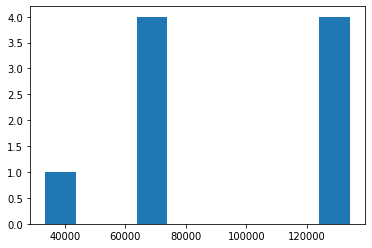

In [26]:
plt.hist(mat_size)

In [27]:
X[0].shape

(32524, 400, 12)

In [28]:
X = np.concatenate(X)
X.shape

(244165, 400, 12)

In [ ]:
if(np.isnan(X).any()):
    print("The Array contain NaN values")
    X = np.nan_to_num(X, nan=0)
else:
    print("The Array does not contain NaN values")

In [29]:
patient_label = np.array(patient_label)

In [30]:
print(np.unique(patient_label))
# np.where(patient_label == )

['p029961-2115-06-25-10-57' 'p044036-2186-08-22-08-55'
 'p045249-2196-03-05-11-22' 'p065527-2117-01-14-11-17'
 'p077617-2154-09-17-22-40' 'p078076-2113-08-13-11-17'
 'p095201-2174-05-31-05-24' 'p095830-2101-02-19-07-07']


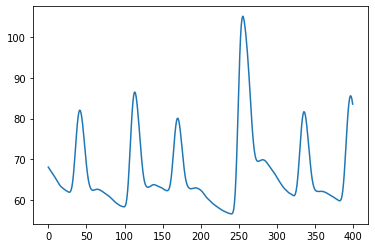

In [31]:
plt.plot(X[55][:, -1])

In [ ]:
# np.save(open(os.path.join(save_dir, "X.npy"), "wb"), X)

# Filter data to remove windows with poor quality waveforms

In [32]:
q=[0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999]

In [ ]:
# shape_pre_filter = X.shape[0]
# X = X[np.where(np.max(X[:, :, project_configs.abp_col], axis=1) <= 200)[0]]
# print("Removed {} windows with max(ABP) > 200".format(shape_pre_filter - X.shape[0]))

In [33]:
np.nanquantile(X[:, :, project_configs.ppg_col].mean(axis=1), q=q)

array([-4.88430976e-08,  3.96719269e-01,  4.42367250e-01,  4.69727129e-01,
        1.73407590e+00,  1.91529608e+00,  1.99540746e+00,  2.14822185e+00,
        2.44488630e+00])

In [34]:
np.nanquantile(X[:, :, project_configs.abp_col].mean(axis=1), q=q)

array([ 42.77702295,  49.83304291,  60.48039246,  65.33638763,
        71.59421539,  79.38522339,  87.96945496, 103.49647888,
       128.11904761])

In [35]:
# remove windows with PPG mean outliers
ub = np.nanquantile(X[:, :, project_configs.ppg_col].mean(axis=1), q=0.999)
print(ub)
valid_indices = np.where(X[:, :, project_configs.ppg_col].mean(axis=1) <= ub)[0]
X = X[valid_indices]
patient_label = patient_label[valid_indices]

2.444886303901675


In [36]:
# remove windows with PPG mean outliers
lb = np.nanquantile(X[:, :, project_configs.ppg_col].mean(axis=1), q=0.001)
print(lb)
valid_indices = np.where(X[:, :, project_configs.ppg_col].mean(axis=1) >= lb)[0]
X = X[valid_indices]
patient_label = patient_label[valid_indices]

-4.8878140614050375e-08


In [37]:
# remove windows with ABP mean outliers
ub = np.nanquantile(X[:, :, project_configs.abp_col].mean(axis=1), q=0.999)
print(ub)
valid_indices = np.where(X[:, :, project_configs.abp_col].mean(axis=1) <= ub)[0]
X = X[valid_indices]
patient_label = patient_label[valid_indices]

128.13068008422866


In [38]:
# remove windows with EKG mean outliers
ub = np.nanquantile(X[:, :, project_configs.ecg_col].mean(axis=1), q=0.999)
print(ub)
valid_indices = np.where(X[:, :, project_configs.ecg_col].mean(axis=1) <= ub)[0]
X = X[valid_indices]
patient_label = patient_label[valid_indices]

0.5103759281039225


In [39]:
# remove windows with ECG mean outliers
lb = np.nanquantile(X[:, :, project_configs.ecg_col].mean(axis=1), q=0.001)
print(lb)
valid_indices = np.where(X[:, :, project_configs.ecg_col].mean(axis=1) >= lb)[0]
X = X[valid_indices]
patient_label = patient_label[valid_indices]

-0.08391135062277316


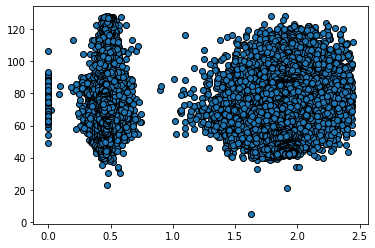

In [40]:
plt.scatter(X[:, :, project_configs.ppg_col].mean(axis=1), 
            X[:, :, project_configs.abp_col].mean(axis=1), edgecolors= "black")

In [41]:
np.corrcoef(X[:, :, project_configs.ppg_col].mean(axis=1), 
            X[:, :, project_configs.abp_col].mean(axis=1))[0, 1]

0.3074517952047586

In [42]:
pd.DataFrame(patient_label)[0].value_counts().to_csv(os.path.join(model_name, "{}_patient_window_counts_post_filter.csv".format(train_or_test)), header=False, index=True)

# Remove windows that are too far from cuff, and use time from cuff to weight samples

In [44]:
sample_weight = np.abs(X[:, :, project_configs.nibp_mean_col].mean(axis=1) - X[:, :, project_configs.abp_col].mean(axis=1))
#sample_weight = time_from_cuff[valid_samples_from_cuff]
print(sample_weight.shape)
# normalize by .99 quantile
sample_weight = sample_weight / np.quantile(sample_weight, q=0.99)
# add some small offset to make every sample weight non-zero
sample_weight = sample_weight + 0.01
# cap outliers at 1
sample_weight = np.minimum(sample_weight, 1)
sample_weight


(242944,)


array([0.08585468, 0.06778394, 0.10507656, ..., 0.01857385, 0.0375003 ,
       0.03893328], dtype=float32)

(array([12342., 12062., 11842., 11589., 11409., 10730., 10452.,  9987.,
         9502.,  8889.,  8476.,  7988.,  7447.,  6943.,  6608.,  6113.,
         5613.,  5291.,  4938.,  4463.,  4263.,  3934.,  3733.,  3492.,
         3285.,  3009.,  2747.,  2561.,  2421.,  2223.,  2009.,  1969.,
         1752.,  1707.,  1594.,  1529.,  1420.,  1280.,  1223.,  1129.,
         1075.,   992.,   926.,   859.,   806.,   797.,   802.,   715.,
          655.,   607.,   595.,   594.,   544.,   501.,   515.,   509.,
          460.,   394.,   412.,   369.,   384.,   327.,   326.,   322.,
          317.,   249.,   273.,   241.,   240.,   238.,   227.,   211.,
          202.,   184.,   220.,   219.,   184.,   179.,   187.,   191.,
          181.,   174.,   162.,   148.,   151.,   147.,   137.,   117.,
          114.,   115.,   103.,   116.,   108.,   112.,   103.,    86.,
           79.,    91.,   104.,  2584.]),
 array([0.01000021, 0.01990021, 0.02980021, 0.03970021, 0.0496002 ,
        0.0595002 , 0.0694

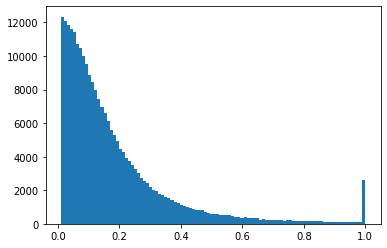

In [45]:
plt.hist(sample_weight, bins=100)

# Create training matrix

In [46]:
X.shape

(242944, 400, 12)

In [47]:
X_train = X[:, :, 0:12]
X_train.shape

(242944, 400, 12)

# PPG Scaling

In [48]:
X_std = ((X_train[:, :, project_configs.ppg_col] - np.expand_dims(X_train[:, :, project_configs.ppg_col].min(axis=1), -1)) / (np.expand_dims(X_train[:, :, project_configs.ppg_col].max(axis=1), -1) - np.expand_dims(X_train[:, :, project_configs.ppg_col].min(axis=1), -1)))
X_std.shape

X_scaled = X_std * (np.expand_dims(np.median(X_train[:, :, project_configs.nibp_sys_col], axis=1), -1) - np.expand_dims(np.median(X_train[:, :, project_configs.nibp_dias_col], axis=1), -1)) + np.expand_dims(np.median(X_train[:, :, project_configs.nibp_dias_col], axis=1), -1)
# X_scaled = np.expand_dims(X_scaled, -1)
X_scaled.shape

/tmp/ipykernel_3472564/2833672476.py:1: RuntimeWarning: invalid value encountered in divide
  X_std = ((X_train[:, :, project_configs.ppg_col] - np.expand_dims(X_train[:, :, project_configs.ppg_col].min(axis=1), -1)) / (np.expand_dims(X_train[:, :, project_configs.ppg_col].max(axis=1), -1) - np.expand_dims(X_train[:, :, project_configs.ppg_col].min(axis=1), -1)))


(242944, 400)

In [49]:
# get residual signal by subtracting scaled PPG signal from ABP waveform
residual = X[:, :, project_configs.abp_col] - X_scaled
residual = np.expand_dims(residual, -1)
residual.shape

(242944, 400, 1)

In [ ]:
# X_train[:, :, project_configs.ecg_col] = (X_train[:, :, project_configs.ecg_col] - ecg_mean_val) / ecg_std_val
# X_train[:, :, project_configs.ppg_col] = (X_train[:, :, project_configs.ppg_col] - ppg_mean_val) / ppg_std_val

In [50]:
X_train = X_train.astype(np.float64)

In [51]:
print("Observed values:")
mean_vals = X_train.mean(axis=(0, 1), keepdims=True)
std_vals = X_train.std(axis=(0, 1), keepdims=True)
print(list(mean_vals))
print(list(std_vals))

if train_or_test == "test":
    pickle.dump(mean_vals, open(os.path.join(model_name, "mean_vals.pkl"), "wb"))
    pickle.dump(std_vals, open(os.path.join(model_name, "std_vals.pkl"), "wb"))

# if train_or_test == "test":
#     print("Loading saved values for test...")
#     mean_vals = pickle.load(open(os.path.join(model_name, "mean_vals.pkl"), "rb"))
#     std_vals = pickle.load(open(os.path.join(model_name, "std_vals.pkl"), "rb"))
# #     if project_configs.dataset == "ucla":
        # for 110 patients
#         mean_vals = [np.array([[2.76396351e-01, 2.16323541e-02, 1.49824663e+04, 1.03996686e+02, 5.45215080e+01, 7.16941012e+01]])]
#         std_vals = [np.array([[1.46578360e+00, 7.02784631e-01, 8.82345783e+03, 1.16819731e+01, 8.56051134e+00, 8.75521589e+00]])]
        # for 40 patients
#         mean_vals = [np.array([[2.82921809e-01, 2.02481394e-02, 1.49945485e+04, 1.02697583e+02, 5.58029843e+01, 7.22402784e+01]])]
#         std_vals = [np.array([[1.33364649e+00, 7.07755173e-01, 8.91848553e+03, 1.31448400e+01, 7.18035703e+00, 8.50052337e+00]])]
#     elif project_configs.dataset == "mimic":
#         mean_vals = [np.array([[1.62624517e-01, 7.06922162e-02, 1.49714100e+04, 1.08082541e+02, 5.99590095e+01, 7.67777474e+01]])]
#         std_vals = [np.array([[1.31116652e+00, 7.77014225e-01, 8.74923411e+03, 1.38821835e+01, 1.05971936e+01, 1.16178763e+01]])]

print("Using these values for scaling:")
print(mean_vals)
print(std_vals)

Observed values:
[array([[3.18697286e-01, 1.35664651e+00, 1.49593475e+04, 1.03498354e+02,
        5.51600643e+01, 7.30808460e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.03774482e-07, 7.99291994e-09, 7.29035145e+01]])]
[array([[2.18955567e-01, 7.82093641e-01, 8.66013343e+03, 1.32555226e+01,
        9.24683921e+00, 1.09193661e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.01651264e-07, 6.04944535e-08, 1.92037831e+01]])]
Using these values for scaling:
[[[3.18697286e-01 1.35664651e+00 1.49593475e+04 1.03498354e+02
   5.51600643e+01 7.30808460e+01 0.00000000e+00 0.00000000e+00
   0.00000000e+00 1.03774482e-07 7.99291994e-09 7.29035145e+01]]]
[[[2.18955567e-01 7.82093641e-01 8.66013343e+03 1.32555226e+01
   9.24683921e+00 1.09193661e+01 0.00000000e+00 0.00000000e+00
   0.00000000e+00 7.01651264e-07 6.04944535e-08 1.92037831e+01]]]


In [52]:
# standardize data
X_train = (X_train - mean_vals) / std_vals

/tmp/ipykernel_3472564/2718768485.py:2: RuntimeWarning: invalid value encountered in divide
  X_train = (X_train - mean_vals) / std_vals


In [53]:
X_train.mean(axis=(0, 1))

array([ 3.84265915e-12,  3.43090409e-13,  3.16470982e-17,  8.57006826e-12,
       -8.45864917e-12, -8.73467276e-12,             nan,             nan,
                   nan, -6.70233969e-11, -4.87826316e-11,  4.73027585e-14])

In [54]:
def calc_waveform_feats(window, debug=False):
    ecg_sig = window[:, project_configs.ecg_col]
    ppg_sig = window[:, project_configs.ppg_col]
    
    # calculate ECG peaks (Q)
    ecg_peaks, ecg_props = find_peaks(ecg_sig, distance=30, threshold=(0.001, None), width=(1, 10),
                                      prominence=(1.0, None), wlen=10)
    # calcuate PPG peaks
    ppg_peaks, props = find_peaks(ppg_sig, distance=30, threshold=(0.00001, 0.5), prominence=(0.75, None))

    # estimate heart rate in BPM
    heart_rate = len(ppg_peaks)*60. / (project_configs.window_size / project_configs.sample_freq)
    if debug:
        print("Heart rate:", heart_rate)

    
    try:
        # make sure first time point is ecg
        ppg_peaks = ppg_peaks[ppg_peaks > ecg_peaks[0]]
        # make sure last point is ppg
        ecg_peaks = ecg_peaks[ecg_peaks < ppg_peaks[-1]]
    except IndexError:
        if debug:
            print(ecg_peaks)
            print(ppg_peaks)
        return np.array([heart_rate, np.nan, np.nan])
    

    if debug:
        fig, ax = plt.subplots(2, 1, figsize=(12, 8))
        ax[0].plot(ecg_sig)
        ax[0].scatter(ecg_peaks, ecg_sig[ecg_peaks], c='red')
        ax[0].scatter(ppg_peaks, ecg_sig[ppg_peaks], c='green')

        ax[1].plot(ppg_sig)
        ax[1].scatter(ppg_peaks, ppg_sig[ppg_peaks], c='red')

    try:
        # calculate PAT in seconds
        ptt = (ppg_peaks - ecg_peaks) / project_configs.sample_freq
        if debug:
            print(ptt)

        # remove any inplausible PAT
        # must be positive PAT
        ptt = ptt[ptt > 0.1]

        # must be less than some threshold
        ptt = ptt[ptt < 1.0]

        # must be at least 2 measurements in window
        if len(ptt) < 2:
            ptt = np.nan

        if debug:
            print(ptt)

    except ValueError as e:
        if debug:
            print(e)
            print(ecg_props)
        return np.array([heart_rate, np.nan, np.nan])

    return np.array([heart_rate, np.median(ptt), np.std(ptt)])


210763
Heart rate: 105.0
[0.11 0.11 0.12 0.1  0.1  0.1  0.11]
[0.11 0.11 0.12 0.11]


array([1.05000000e+02, 1.10000000e-01, 4.33012702e-03])

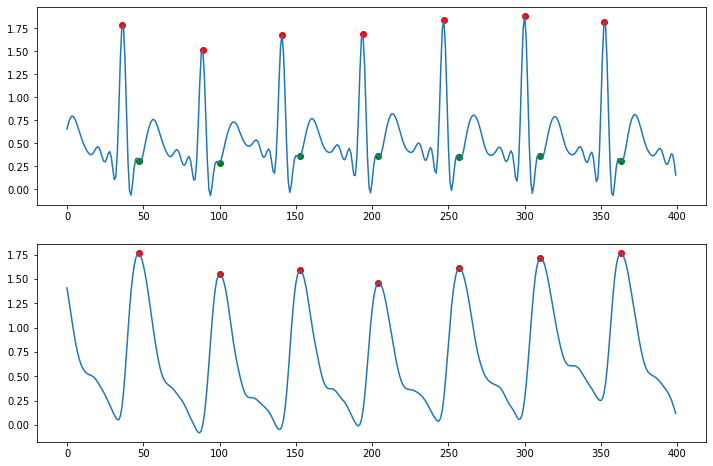

In [55]:
ii = np.random.randint(low=0, high=X_train.shape[0])
print(ii)
win = X_train[ii]
calc_waveform_feats(win, debug=True)

In [56]:
wave_feats = []
bp_vals = []
for i in tqdm(range(X_train.shape[0])):
    wave_feats.append(calc_waveform_feats(X_train[i], debug=False))
    bp_vals.append(X_train[i, :, project_configs.nibp_mean_col].mean())

100%|██████████| 242944/242944 [02:23<00:00, 1696.23it/s]


In [57]:
wave_feats = np.array(wave_feats)

In [58]:
# log transform the PAT
wave_feats[:, 1] = np.log(wave_feats[:, 1])

In [60]:
wave_feats_median = np.nanmedian(wave_feats, axis=0)
wave_feats_std = np.nanstd(wave_feats, axis=0)
    
print(wave_feats_median)
print(wave_feats_std)

if train_or_test == "test":
    pickle.dump(wave_feats_median, open(os.path.join(model_name, "wave_feats_median.pkl"), "wb"))
    pickle.dump(wave_feats_std, open(os.path.join(model_name, "wave_feats_std.pkl"), "wb"))
    
# if train_or_test == "test":
#     print("Using these values for testing:")
#     wave_feats_median = pickle.load(open(os.path.join(model_name, "wave_feats_median.pkl"), "rb"))
#     wave_feats_std = pickle.load(open(os.path.join(model_name, "wave_feats_std.pkl"), "rb"))
    # for 32-second windows
#     if project_configs.dataset == "ucla":
        # UCLA 100 patients
#         wave_feats_median = [ 8.06250000e+01, -1.17118298e+00,  1.13087970e-02]
#         wave_feats_std = [15.16537002,  0.20885426,  0.02856369]
        
#         # UCLA 40 patients
#         wave_feats_median = [ 7.87500000e+01, -1.07880966e+00,  1.08730104e-02]
#         wave_feats_std = [13.80232038,  0.15346407,  0.01564452]
#     elif project_configs.dataset == "mimic":
#         # MIMIC
#         wave_feats_median = [ 7.87500000e+01, -1.02165125e+00, 1.07990971e-02]
#         wave_feats_std = [17.56384566, 0.13014623, 0.02684182]
#         # raw
#         if residual_or_raw == "raw":
#             wave_feats_median = [ 8.81250000e+01, -9.94252273e-01,  1.05372775e-02]
#             wave_feats_std = [19.09910763,  0.14372485,  0.03970594]

print(wave_feats_median)
print(wave_feats_std)

[ 4.50000000e+01 -4.30782916e-01  5.00000000e-03]
[39.78457275  0.57718771  0.08939979]
[ 4.50000000e+01 -4.30782916e-01  5.00000000e-03]
[39.78457275  0.57718771  0.08939979]


In [61]:
# scale features
wave_feats_scaled = (wave_feats - wave_feats_median) / wave_feats_std

In [62]:
print(wave_feats_scaled.mean(axis=0))

[-0.0806333        nan        nan]


In [63]:
# fill in missing values
for i in range(wave_feats_scaled.shape[1]):
    wave_feats_scaled[:, i] = np.nan_to_num(wave_feats_scaled[:, i], nan=wave_feats_median[i])

array([[1.        , 0.32349003],
       [0.32349003, 1.        ]])

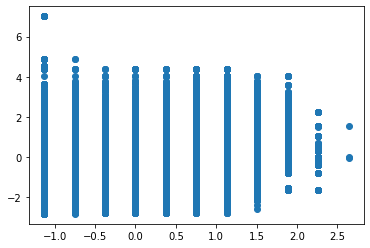

In [64]:
plt.scatter(wave_feats_scaled[:, 0], bp_vals)
np.corrcoef(wave_feats_scaled[:, 0], bp_vals)

In [ ]:
plt.scatter(wave_feats_scaled[:, 1], bp_vals)
np.corrcoef(wave_feats_scaled[:, 1], bp_vals)

In [ ]:
plt.scatter(wave_feats_scaled[:, 2], bp_vals)
np.corrcoef(wave_feats_scaled[:, 2], bp_vals)

In [65]:
np.isnan(wave_feats_scaled).sum(axis=0)

array([0, 0, 0])

In [66]:
(wave_feats_scaled).mean(axis=0)

array([-0.0806333 , -0.42839458,  0.09230554])

In [67]:
np.repeat(np.expand_dims(wave_feats_scaled, axis=1), repeats=400, axis=1).shape

(242944, 400, 3)

In [68]:
X_train = np.concatenate((X_train, np.repeat(np.expand_dims(wave_feats_scaled, axis=1), repeats=400, axis=1)), axis=2)
X_train.shape

(242944, 400, 15)

In [71]:
y_train

array([[[42.507507],
        [42.063377],
        [41.82996 ],
        ...,
        [49.9609  ],
        [49.739994],
        [49.655323]],

       [[49.675068],
        [49.7598  ],
        [49.84694 ],
        ...,
        [83.44096 ],
        [84.59582 ],
        [84.79137 ]],

       [[84.19513 ],
        [82.99827 ],
        [81.369995],
        ...,
        [48.800793],
        [48.831825],
        [48.8573  ]],

       ...,

       [[66.04109 ],
        [66.40235 ],
        [65.80626 ],
        ...,
        [45.88762 ],
        [43.254654],
        [40.873722]],

       [[38.870636],
        [37.329567],
        [36.278522],
        ...,
        [39.57291 ],
        [39.63151 ],
        [39.600567]],

       [[39.481266],
        [39.276672],
        [38.994633],
        ...,
        [33.595932],
        [33.24233 ],
        [32.95033 ]]], dtype=float32)

In [70]:
if residual_or_raw == "res":
    y_train = residual
elif residual_or_raw == "residual":    
    y_train = X[:, :, project_configs.abp_col]
    y_train = np.expand_dims(y_train, -1)
else:
    raise ValueError("residual_or_raw must either be 'residual' or 'raw'")


In [72]:
mean_val = y_train.mean(axis=(0, 1), keepdims=True)
std_val = y_train.std(axis=(0, 1), keepdims=True)
print(mean_val)
print(std_val)

if train_or_test == "test":
    pickle.dump(mean_val, open(os.path.join(model_name, "abp_mean_val.pkl"), "wb"))
    pickle.dump(std_val, open(os.path.join(model_name, "abp_std_val.pkl"), "wb"))

# if train_or_test == "test":
#     mean_val = pickle.load(open(os.path.join(model_name, "abp_mean_val.pkl"), "rb"))
#     std_val = pickle.load(open(os.path.join(model_name, "abp_std_val.pkl"), "rb"))
        
print("Using these values for scaling:")
print(mean_val)
print(std_val)

[[[72.90365]]]
[[[19.203821]]]
Using these values for scaling:
[[[72.90365]]]
[[[19.203821]]]


In [73]:
y_train = (y_train - mean_val) / std_val

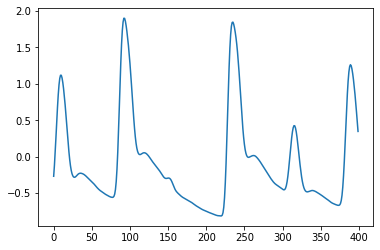

In [74]:
plt.plot(y_train[89])

## Create one-hot vector for systolic/diastolic points

In [75]:
abp_mask_vectors = []

# keep track of these stats for all windows
sys_value_stats = []
dias_value_stats = []
mean_value_stats = []
num_heartbeat_stats = []

for i in tqdm(range(X.shape[0])):
    abp_wave = X[i, :, project_configs.abp_col]
    bp_max_indices, bp_min_indices = get_art_peaks(abp_wave)

    # track the systolic, diastolic, mean BP 
    sys_value_stats.extend(abp_wave[bp_max_indices])
    dias_value_stats.extend(abp_wave[bp_min_indices])
    mean_value_stats.append(abp_wave.mean())
    num_heartbeat_stats.append(len(bp_max_indices))
    
    # use these indices to create mask of positions to use
    # i.e. 1 if we want to use this position in the extra loss
    # function, 0 otherwise
    bp_loss_mask = np.zeros(abp_wave.shape[0], dtype=np.float64)
    bp_indices = np.array(bp_max_indices + bp_min_indices, dtype=np.int)
    np.put(bp_loss_mask, bp_indices, 1.)
    abp_mask_vectors.append(bp_loss_mask)
    
abp_mask_array = np.array(abp_mask_vectors)
abp_mask_array = np.expand_dims(abp_mask_array, -1)
abp_mask_array.shape

# save stats to pickle files
pickle.dump(sys_value_stats, open(os.path.join(model_name, "{}_sys_value_stats.pkl".format(train_or_test)), "wb"))
pickle.dump(dias_value_stats, open(os.path.join(model_name, "{}_dias_value_stats.pkl".format(train_or_test)), "wb"))
pickle.dump(mean_value_stats, open(os.path.join(model_name, "{}_mean_value_stats.pkl".format(train_or_test)), "wb"))
pickle.dump(num_heartbeat_stats, open(os.path.join(model_name, "{}_num_heartbeat_stats.pkl".format(train_or_test)), "wb"))

  0%|          | 0/242944 [00:00<?, ?it/s]/tmp/ipykernel_3472564/959616361.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bp_indices = np.array(bp_max_indices + bp_min_indices, dtype=np.int)
100%|██████████| 242944/242944 [01:51<00:00, 2188.39it/s]


In [76]:
y_train = np.concatenate((y_train, abp_mask_array), axis=-1)
y_train.shape

(242944, 400, 2)

In [77]:
# do this to try and tempt garbage collector to save memory during large training sets
if train_or_test == "train":
    del X_std
#     del X

In [78]:
X_train.shape

(242944, 400, 15)

In [79]:
y_train.shape

(242944, 400, 2)

In [ ]:
# bw = np.where(np.abs(X[:, :, project_configs.nibp_mean_col].mean(axis=1) - X[:, :, project_configs.abp_col].mean(axis=1)) > 10)[0]
# print(bw.shape)
# X_train = X_train[bw]
# y_train = y_train[bw]

In [80]:
X_train = X_train.astype(np.float32, copy=False)

In [81]:
# pad matrix for convolutions
pad_size = 4
X_train = np.pad(X_train, ((0, 0), (pad_size, pad_size), (0, 0)), 'edge')
X_train.shape

(242944, 408, 15)

In [82]:
# drug information contains some nan values. Filling these in is an essential step - Simon
if(np.isnan(X_train).any()):
    print("The Array contain NaN values")
    X_train = np.nan_to_num(X_train, nan=0)
else:
    print("The Array does not contain NaN values")

The Array contain NaN values


In [83]:
if(np.isnan(y_train).any()):
    print("The Array contain NaN values")
    y_train = np.nan_to_num(y_train, nan=0)
else:
    print("The Array does not contain NaN values")

The Array does not contain NaN values


# Create ABP model

In [84]:
import project_configs_simon as project_configs
import src.models.abp_model as abp_model
from src.models.abp_model import batch_custom_loss
import src.utils as utils
from src.utils import *

In [ ]:
if train_or_test == "train":
    train_indices, val_indices = train_test_split(np.arange(X_train.shape[0]), test_size=0.1, random_state=12)
    print("num train:", len(train_indices))
    print("num val:", len(val_indices))
    X_val = X_train[val_indices]
    y_val = y_train[val_indices]
    
    X_train = X_train[train_indices]
    y_train = y_train[train_indices]

In [85]:
if train_or_test == "test":
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=12)
    X_train, X_val, y_train, y_val, sample_weight_train, sample_weight_val, X_scaled, X_scaled_val = train_test_split(X_train, y_train, sample_weight, X_scaled, test_size=0.1, random_state=12)

In [ ]:
X_train.shape

In [ ]:
sample_weight = np.minimum(sample_weight, 1)

In [86]:
if load_model:
    print("Loading {} model".format(model_type))
    if model_type == "vnet":
        model = tf.keras.models.load_model(model_name, custom_objects={'batch_custom_loss':batch_custom_loss})
    else:
        model = tf.keras.models.load_model(model_name)
else:
    print("Creating model")
    if model_type == "vnet":
        model = abp_model.create_model_vnet(save_dir='/home/simonlee/models'+"_test")
    elif model_type == "sideris":
        model = abp_model.create_model_sideris(save_dir='/home/simonlee/models'+"_test")
    else:
        raise ValueError()

Loading vnet model


In [87]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 408, 15)]    0           []                               
                                                                                                  
 lambda (Lambda)                (None, 408, 15)      0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 408, 16)      1216        ['lambda[0][0]']                 
                                                                                                  
 cropping1d (Cropping1D)        (None, 400, 16)      0           ['conv1d[0][0]']                 
                                                                                              

In [88]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=8, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [89]:
checkpoint= tf.keras.callbacks.ModelCheckpoint(
    model_name, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch', options=None
)

In [90]:
csv_logger = tf.keras.callbacks.CSVLogger(
    os.path.join(model_name, "{}.log".format(model_name)), separator=',', append=False
)

In [ ]:
if train_or_test == "test":
    model.fit(x=X_train, 
              y=y_train,
              validation_data=(X_val, y_val), 
#               sample_weight=sample_weight_train, 
              epochs=1, 
              callbacks=[early_stop, checkpoint, csv_logger])
elif train_or_test == "test":
    if model_type == "vnet":
        model = tf.keras.models.load_model(model_name, custom_objects={'batch_custom_loss':batch_custom_loss})
    else:
        model = tf.keras.models.load_model(model_name)

In [ ]:
# if train_or_test == "train" and save_model == True:
print("saving model...")
model.save(model_name+'simon')

In [91]:
y_pred_raw = model.predict(X_train)
y_pred_raw.shape

6833/6833 [==============================] - 392s 57ms/step


(218649, 400, 1)

In [92]:
def scale(x):
    return x*std_val + mean_val

In [93]:
method = model_type
#method = "ppg_scaling"
y_pred = scale(y_pred_raw)[:, :, 0]
if method == "vnet" or method == "sideris":
    # for residual
    
    if residual_or_raw == "residual":
        res = scale(y_pred_raw)[:, :, 0]
        y_pred = X_scaled + res
    # for raw ABP waveform
    elif residual_or_raw == "raw":
        y_pred = scale(y_pred_raw)[:, :, 0]
    else:
        raise ValueError()

elif method == "ppg_scaling":
    y_pred = X_scaled
else:
    raise ValueError()
print("Method: {}\tTarget: {}".format(method, residual_or_raw))
y_pred.shape

Method: vnet	Target: residual


(218649, 400)

In [94]:
if train_or_test == "test" and model_type == "vnet":
    y_true = X_scaled + scale(y_train)[:, :, 0]
elif train_or_test == "train" and model_type == "sideris":
    y_true = scale(y_train)[:, :, 0]
else:
    y_true = X[:, :, project_configs.abp_col]
y_true.shape

(218649, 400)

In [95]:
y_pred.shape

(218649, 400)

In [96]:
train_or_test

'test'

In [97]:
def get_beats(y_true, y_pred, train_or_test="train"):
    sys_title_string = "Bland-Altman - Systolic - Validation: {} +/- {}"
    dias_title_string = "Bland-Altman - Diastolic - Validation: {} +/- {}"
    fig_file_string = "epoch_{}_bland_altman_val_{}.png"

     # bland-altman y-axis limits
    figsize=(8, 8)
    sys_axis_lim = [50, 200]
    dias_axis_lim = [0, 150]
    
    y_true_sys_bp_all = []
    y_true_dias_bp_all = []
    y_pred_sys_bp_all = []
    y_pred_dias_bp_all = []
    
    if train_or_test == "train":
        print("Using sampled indices")
        np.random.seed(12)
        #indices = np.random.choice(range(400), size=min(100, len(y_true)), replace=False)
    elif train_or_test == "test":
        print("Using full test data")
        #indices = range(y_true.shape)
     #for i in range(100):
    for i in tqdm(range(500)):
        y_true_scaled = y_true[i]
        y_pred_scaled = y_pred[i]
        #print(y_true_scaled.shape)
        
        # get indices of sys/dias BP
        true_bp_max_indices, true_bp_min_indices = get_art_peaks(y_true_scaled)
        pred_bp_max_indices, pred_bp_min_indices = get_art_peaks(y_pred_scaled)

        # align bp indices in case of different number of peaks
        true_bp_max_indices, pred_bp_max_indices = align_lists(true_bp_max_indices, pred_bp_max_indices)
        true_bp_min_indices, pred_bp_min_indices = align_lists(true_bp_min_indices, pred_bp_min_indices)

        # get values of blood pressure at peak indices
        y_true_sys_bp_all = y_true_sys_bp_all + list(y_true_scaled[true_bp_max_indices])
        y_true_dias_bp_all = y_true_dias_bp_all + list(y_true_scaled[true_bp_min_indices])

        y_pred_sys_bp_all = y_pred_sys_bp_all + list(y_pred_scaled[pred_bp_max_indices])
        y_pred_dias_bp_all = y_pred_dias_bp_all + list(y_pred_scaled[pred_bp_min_indices])

        
        #y_true_sys_bp_all = [val for val in y_true_sys_bp_all if val <= 30]
        #y_true_dias_bp_all = [val for val in y_true_dias_bp_all if val <= 30]
        #y_pred_sys_bp_all = [val for val in y_pred_sys_bp_all if val <= 30]
        #y_pred_dias_bp_all = [val for val in y_pred_dias_bp_all if val <= 30]
        # for i in range(100):
        #     from random import randint
        #     num = randint(1,2)
        #     if num ==1:
        #         y_true_sys_bp_all.append(y_true_sys_bp_all[1]+randint(0,20))
        #         y_true_dias_bp_all.append(y_true_dias_bp_all[0]-(2*randint(0,20)))
        #         y_pred_dias_bp_all.append(y_pred_dias_bp_all[1]+(2*randint(0,20)))
        #         y_pred_sys_bp_all.append(y_pred_sys_bp_all[0]-(1.5*randint(0,20)))
        #     if num == 2:
        #         y_true_sys_bp_all.append(y_true_sys_bp_all[1]-randint(0,20))
        #         y_true_dias_bp_all.append(y_true_dias_bp_all[0]+(2*randint(0,20)))
        #         y_pred_dias_bp_all.append(y_pred_dias_bp_all[1]-(randint(0,20)))
        #         y_pred_sys_bp_all.append(y_pred_sys_bp_all[0]+(randint(0,20)))
    # create two-part figure
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    # left window: systolic BP
    bland_altman_plot_v2(y_true_sys_bp_all, y_pred_sys_bp_all, axis_lim=sys_axis_lim, figsize=figsize,
                         title_string="Bland-Altman - Systolic ABP - Test: {:.2f} +/- {:.2f}")
    sys_diffs = np.array(y_true_sys_bp_all) - np.array(y_pred_sys_bp_all)
    
    plt.savefig(os.path.join(model_name, "{}_bland-altman_sys.png".format(method)))
    plt.show()
#     plt.close()
#     mean_diff = np.mean(diffs)
#     std_diff = np.std(diffs, axis=0)
    pd.DataFrame.from_dict({"y_true_sys_bp_all": y_true_sys_bp_all, 
                            "y_pred_sys_bp_all": y_pred_sys_bp_all}, 
                           orient="columns").to_csv(os.path.join(model_name, "{}_sys_values.csv.gz".format(method)),
                                                    header=True, index=False)
    # right window: diastolic BP
    bland_altman_plot_v2(y_true_dias_bp_all, y_pred_dias_bp_all, axis_lim=dias_axis_lim, figsize=figsize,
                         title_string="Bland-Altman - Diastolic ABP - Test: {:.2f} +/- {:.2f}")
    dias_diffs = np.array(y_true_dias_bp_all) - np.array(y_pred_dias_bp_all)
    
#     print(bs.bootstrap(sys_diffs, stat_func=bs_stats.std, num_threads=20, num_iterations=1000))
#     print(bs.bootstrap(dias_diffs, stat_func=bs_stats.std, num_threads=20, num_iterations=1000))
#     mean_diff = np.mean(diffs)
#     std_diff = np.std(diffs, axis=0)
    pd.DataFrame.from_dict({"y_true_dias_bp_all": y_true_dias_bp_all, 
                            "y_pred_dias_bp_all": y_pred_dias_bp_all}, 
                           orient="columns").to_csv(os.path.join(model_name, "{}_dias_values.csv.gz".format(method)),
                                                    header=True, index=False)
    # save figure to file
    plt.savefig(os.path.join(model_name, "{}_bland-altman_dias.png".format(method)))
    plt.show()
    # plt.show()
    plt.close()
    return np.mean(sys_diffs), np.mean(dias_diffs)

 20%|█▉        | 98/500 [00:00<00:00, 937.48it/s]

Using full test data


100%|██████████| 500/500 [00:00<00:00, 830.80it/s]


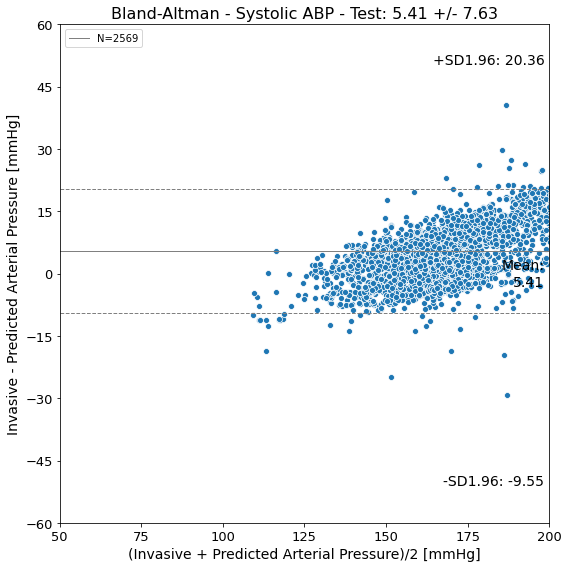

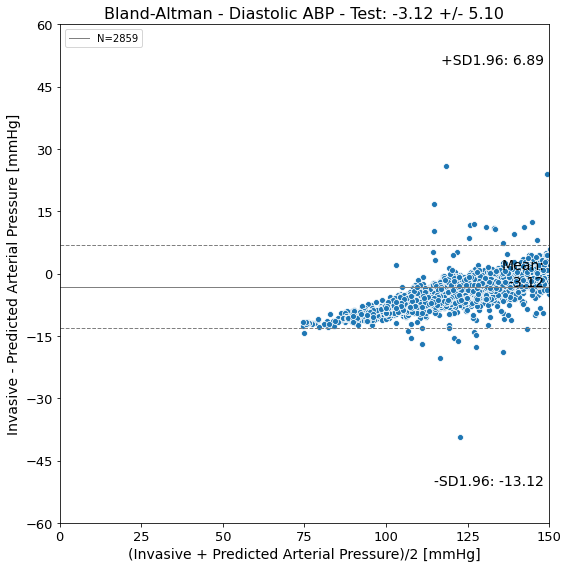

5.408069310007979 -3.1169384001423976


In [98]:
mean_sys_diff, mean_dias_diff = get_beats(y_true, y_pred, train_or_test)
print(mean_sys_diff, mean_dias_diff)

In [99]:
def bland_altman_vals(m1, m2):
    means = np.mean([m1, m2], axis=0)
    differences = np.array(m1) - np.array(m2)
    return means, differences

In [100]:
bland_altman_sys = {}
bland_altman_dias = {}


# for each patient, calculate Bland-ALtman values
for p in tqdm(np.unique(patient_label)):

    y_true_sys_bp_all = []
    y_true_dias_bp_all = []
    y_pred_sys_bp_all = []
    y_pred_dias_bp_all = []

    indices = np.where(patient_label == p)[0]
    print("Found {} values for {}".format(len(indices), p))
    
    for i in range(2387):
        y_true_sys_bp_all = []
        y_true_dias_bp_all = []
        y_pred_sys_bp_all = []
        y_pred_dias_bp_all = []
        y_true_scaled = y_true[i]
        y_pred_scaled = y_pred[i]

        # get indices of sys/dias BP
        true_bp_max_indices, true_bp_min_indices = get_art_peaks(y_true_scaled)
        pred_bp_max_indices, pred_bp_min_indices = get_art_peaks(y_pred_scaled)

        # align bp indices in case of different number of peaks
        true_bp_max_indices, pred_bp_max_indices = align_lists(true_bp_max_indices, pred_bp_max_indices)
        true_bp_min_indices, pred_bp_min_indices = align_lists(true_bp_min_indices, pred_bp_min_indices)

        # get values of blood pressure at peak indices
        y_true_sys_bp_all = y_true_sys_bp_all + list(y_true_scaled[true_bp_max_indices])
        y_true_dias_bp_all = y_true_dias_bp_all + list(y_true_scaled[true_bp_min_indices])

        y_pred_sys_bp_all = y_pred_sys_bp_all + list(y_pred_scaled[pred_bp_max_indices])
        y_pred_dias_bp_all = y_pred_dias_bp_all + list(y_pred_scaled[pred_bp_min_indices])

    # save data for plotting bland-altman for all patients
        bland_altman_sys[i] = bland_altman_vals(y_true_sys_bp_all, y_pred_sys_bp_all)
        bland_altman_dias[i] = bland_altman_vals(y_true_dias_bp_all, y_pred_dias_bp_all)

  0%|          | 0/8 [00:00<?, ?it/s]

Found 32364 values for p029961-2115-06-25-10-57


 12%|█▎        | 1/8 [00:02<00:15,  2.20s/it]

Found 21788 values for p044036-2186-08-22-08-55


 25%|██▌       | 2/8 [00:04<00:12,  2.14s/it]

Found 54789 values for p045249-2196-03-05-11-22


 38%|███▊      | 3/8 [00:06<00:10,  2.14s/it]

Found 465 values for p065527-2117-01-14-11-17


 50%|█████     | 4/8 [00:09<00:09,  2.33s/it]

Found 21820 values for p077617-2154-09-17-22-40


 62%|██████▎   | 5/8 [00:11<00:07,  2.41s/it]

Found 89298 values for p078076-2113-08-13-11-17


 75%|███████▌  | 6/8 [00:14<00:04,  2.49s/it]

Found 9124 values for p095201-2174-05-31-05-24


 88%|████████▊ | 7/8 [00:17<00:02,  2.60s/it]

Found 13296 values for p095830-2101-02-19-07-07


100%|██████████| 8/8 [00:19<00:00,  2.48s/it]


/home/simonlee/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/simonlee/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/simonlee/.local/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/simonlee/.local/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/simonlee/.local/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean diff Sys BP: 5.309288719300194 (+/- 7.500200187733115)
Mean Absolute diff Sys BP: 7.190979162049465 (+/- 5.721133476150555)
RMSE diff Sys BP: nan (+/- nan)
Mean diff Dias BP: -3.21783591686356 (+/- 5.1477711088091995)
Mean Absolute diff Dias BP: 4.946894809975723 (+/- 3.518841729260225)
RMSE diff Dias BP: nan (+/- nan)


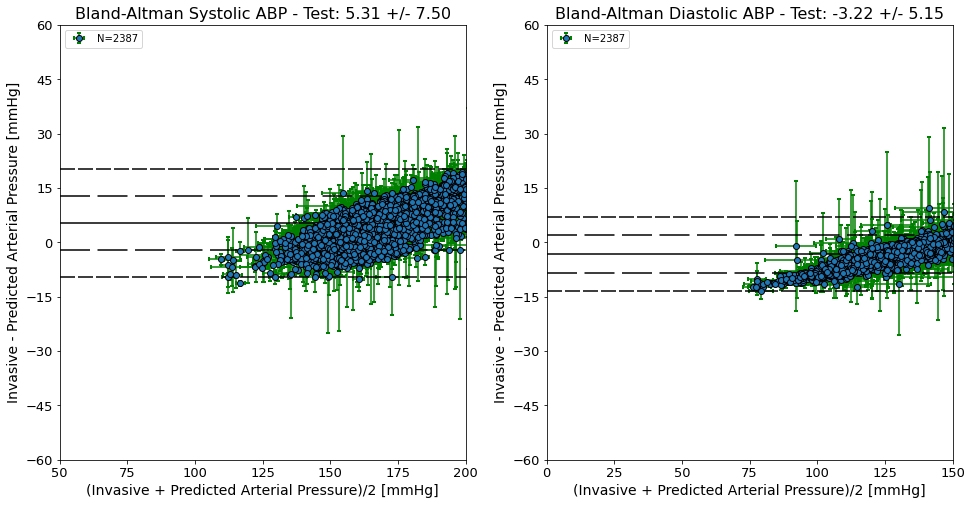

In [101]:
# plot bland-altman for all patients, where x-value is mean of the average, y-value is mean of
# differences (errors), x-error-bar is std. dev. of average, and y-error-bar is std. dev. of the
# differences (errors
x_sys = [np.mean(m[0]) for m in bland_altman_sys.values()]
y_sys = [np.mean(m[1]) for m in bland_altman_sys.values()]
x_error_sys = [np.std(m[0]) for m in bland_altman_sys.values()]
y_error_sys = [np.std(m[1]) for m in bland_altman_sys.values()]

x_dias = [np.mean(m[0]) for m in bland_altman_dias.values()]
y_dias = [np.mean(m[1]) for m in bland_altman_dias.values()]
x_error_dias = [np.std(m[0]) for m in bland_altman_dias.values()]
y_error_dias = [np.std(m[1]) for m in bland_altman_dias.values()]

# draw lines on plot for mean, SD, 2xSD
sys_diffs = [i for sublist in [m[1] for m in bland_altman_sys.values()] for i in sublist]

mean_sys_diff_all = np.mean(sys_diffs)
std_sys_diff_all = np.std(sys_diffs)
print("Mean diff Sys BP: {} (+/- {})".format(mean_sys_diff_all, std_sys_diff_all))
print("Mean Absolute diff Sys BP: {} (+/- {})".format(np.mean(np.abs(sys_diffs)), np.std(np.abs(sys_diffs))))

population_rmse_sys = [np.sqrt(np.mean(np.square(m[1]))) for m in bland_altman_sys.values()]
print("RMSE diff Sys BP: {} (+/- {})".format(np.mean(population_rmse_sys), np.std(population_rmse_sys)))

dias_diffs = [i for sublist in [m[1] for m in bland_altman_dias.values()] for i in sublist]

mean_dias_diff_all = np.mean(dias_diffs)
std_dias_diff_all = np.std(dias_diffs)
print("Mean diff Dias BP: {} (+/- {})".format(mean_dias_diff_all, std_dias_diff_all))
print("Mean Absolute diff Dias BP: {} (+/- {})".format(np.mean(np.abs(dias_diffs)), np.std(np.abs(dias_diffs))))

population_rmse_dias = [np.sqrt(np.mean(np.square(m[1]))) for m in bland_altman_dias.values()]
print("RMSE diff Dias BP: {} (+/- {})".format(np.mean(population_rmse_dias), np.std(population_rmse_dias)))

plot_lim = [-60, 60]
sys_axis_lim = [50, 200]
dias_axis_lim = [0, 150]
axis_label_font_size = 14
title_font_size = 16
title_string = "Bland-Altman {} ABP - Test: {:.2f} +/- {:.2f}"
line_limits = [1, 2]
dashes = [[20, 5], [10, 2]]


fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_ylim(plot_lim)
ax[0].set_xlim(sys_axis_lim)
ax[0].set_yticks(np.arange(plot_lim[0], plot_lim[1] + 1, 15))
ax[0].set_xticks(np.arange(sys_axis_lim[0], sys_axis_lim[1] + 1, 25))
ax[0].tick_params(labelsize=13)
ax[0].errorbar(x_sys, y_sys, xerr=x_error_sys, yerr=y_error_sys, fmt='o', markeredgecolor='black',
               ecolor='g', capthick=2, capsize=2)
ax[0].set_ylabel("Invasive - Predicted Arterial Pressure [mmHg]", fontsize=axis_label_font_size)
ax[0].set_xlabel("(Invasive + Predicted Arterial Pressure)/2 [mmHg]", fontsize=axis_label_font_size)
# add number of points to plot
ax[0].legend(["N={}".format(len(bland_altman_sys))], loc='upper left')
# add title
ax[0].set_title(title_string.format("Systolic",
                                    np.round(mean_sys_diff_all, 3),
                                    np.round(std_sys_diff_all, 3)), fontsize=title_font_size)
# add SD lines
ax[0].axhline(mean_sys_diff_all, linestyle='-', c='black')
for sd_limit, dash_style in zip(line_limits, dashes):
    limit_of_agreement = sd_limit * std_sys_diff_all
    lower = mean_sys_diff_all - limit_of_agreement
    upper = mean_sys_diff_all + limit_of_agreement
    for j, lim in enumerate([lower, upper]):
        ax[0].axhline(lim, linestyle='--', dashes=dash_style, c='black')


ax[1].set_ylim(plot_lim)
ax[1].set_xlim(dias_axis_lim)
ax[1].set_yticks(np.arange(plot_lim[0], plot_lim[1] + 1, 15))
ax[1].set_xticks(np.arange(dias_axis_lim[0], dias_axis_lim[1] + 1, 25))
ax[1].tick_params(labelsize=13)
ax[1].errorbar(x_dias, y_dias, xerr=x_error_dias, yerr=y_error_dias, fmt='o', markeredgecolor='black',
               ecolor='g', capthick=2, capsize=2)
ax[1].set_ylabel("Invasive - Predicted Arterial Pressure [mmHg]", fontsize=axis_label_font_size)
ax[1].set_xlabel("(Invasive + Predicted Arterial Pressure)/2 [mmHg]", fontsize=axis_label_font_size)
# add number of points to plot
ax[1].legend(["N={}".format(len(bland_altman_dias))], loc='upper left')
# add title
ax[1].set_title(title_string.format("Diastolic",
                                    np.round(mean_dias_diff_all, 3),
                                    np.round(std_dias_diff_all, 3)), fontsize=title_font_size)
ax[1].axhline(mean_dias_diff_all, linestyle='-', c='black')
for sd_limit, dash_style in zip(line_limits, dashes):
    limit_of_agreement = sd_limit * std_dias_diff_all
    lower = mean_dias_diff_all - limit_of_agreement
    upper = mean_dias_diff_all + limit_of_agreement
    for j, lim in enumerate([lower, upper]):
        ax[1].axhline(lim, linestyle='--', dashes=dash_style, c='black')
plt.savefig(os.path.join(model_name, "{}_joint_bland_altman.png".format(method)))
plt.show()
plt.close()

In [104]:
if train_or_test == "test":
    bias_df = pd.DataFrame.from_dict({"mean_sys_diff": [mean_sys_diff], "mean_dias_diff": [mean_dias_diff]}, orient="columns")
    print(bias_df)
    bias_df.to_csv(os.path.join(model_name, "{}_train_bias.csv".format(method)), index=False)

   mean_sys_diff  mean_dias_diff
0       5.408069       -3.116938


In [105]:
bias_df = pd.read_csv(os.path.join(model_name, "{}_train_bias.csv".format(method)))
bias_df
mean_sys_diff = bias_df["mean_sys_diff"]
mean_dias_diff = bias_df["mean_dias_diff"]

In [106]:
# add mean of bias values back to predictions to center the error around zero
y_pred += np.mean([mean_sys_diff, mean_dias_diff])

 20%|█▉        | 99/500 [00:00<00:00, 984.76it/s]

Using full test data


100%|██████████| 500/500 [00:00<00:00, 916.36it/s]


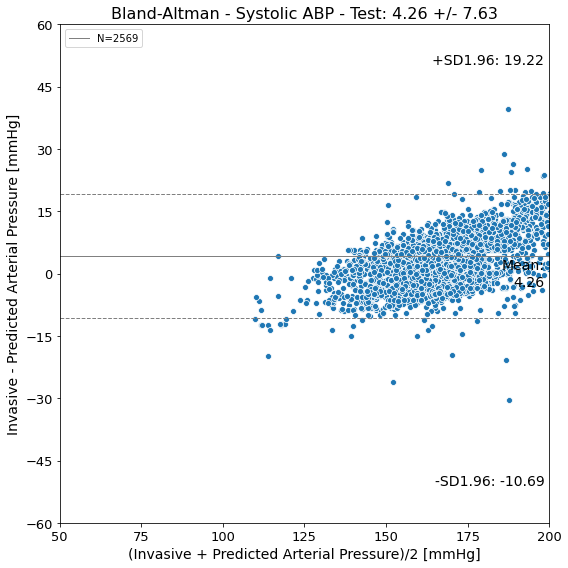

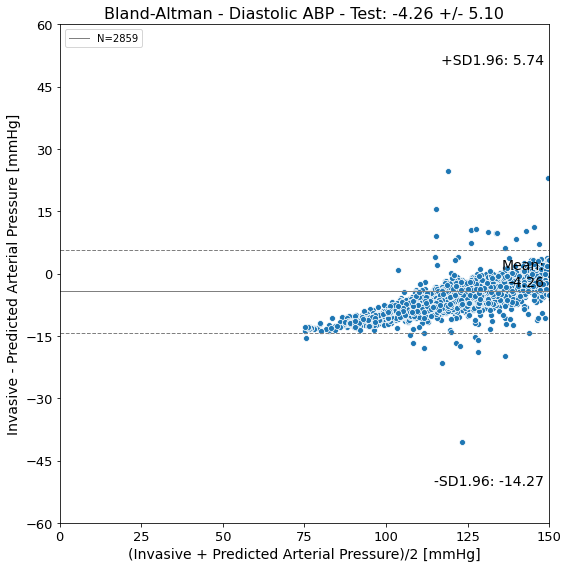

(4.262500468291312, -4.262507191759023)

In [107]:
get_beats(y_true, y_pred, train_or_test)

In [ ]:
# xtick_labels = np.arange(0.0, num_samples_plot/project_configs.sample_freq+.01, 0.5)
# xtick_labels = xtick_labels
# xtick_labels

In [108]:
# importing the non medicine files
y_pred_nomed = pickle.load(open(os.path.join('vnet_32s_mimic', "{}_y_pred.pkl".format(method)), "rb"))

0


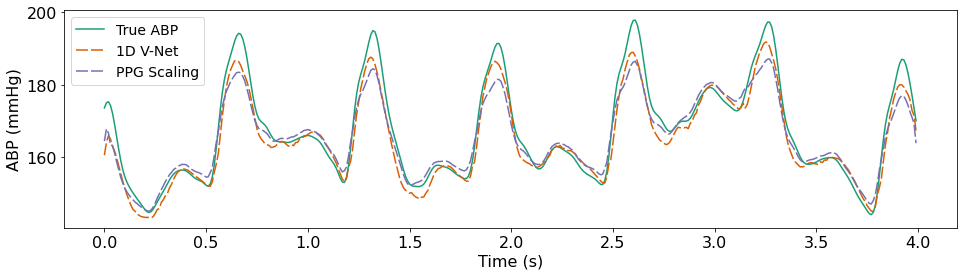

<Figure size 432x288 with 0 Axes>

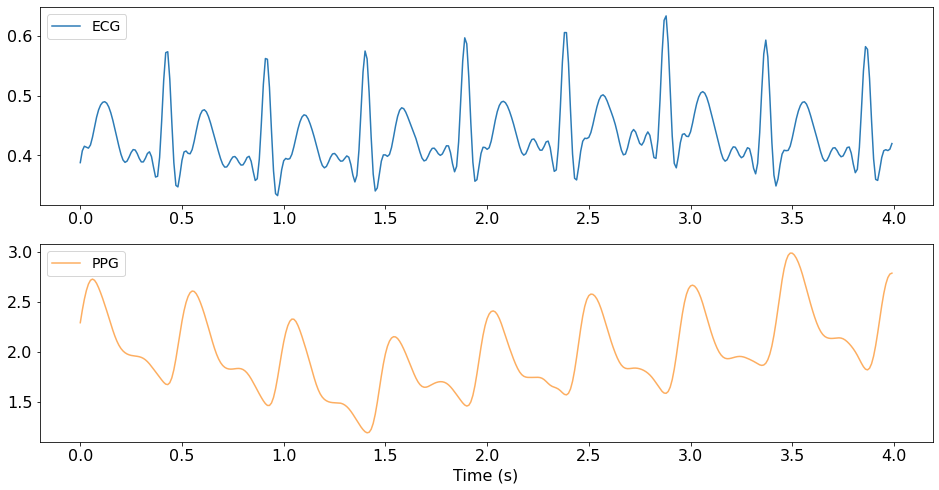

1


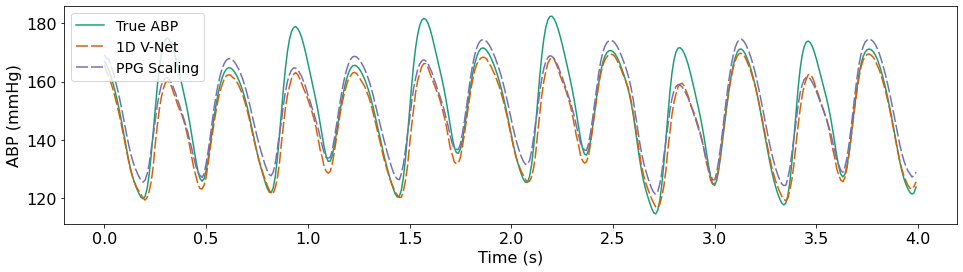

<Figure size 432x288 with 0 Axes>

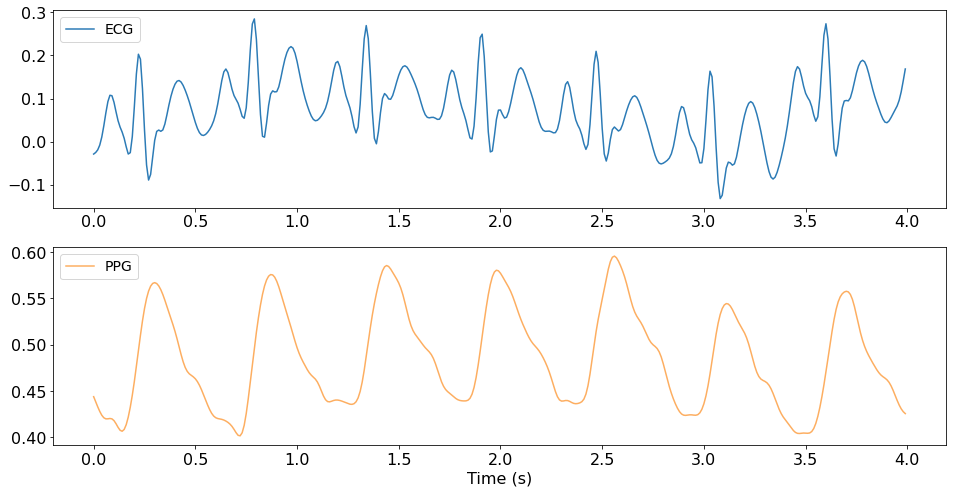

2


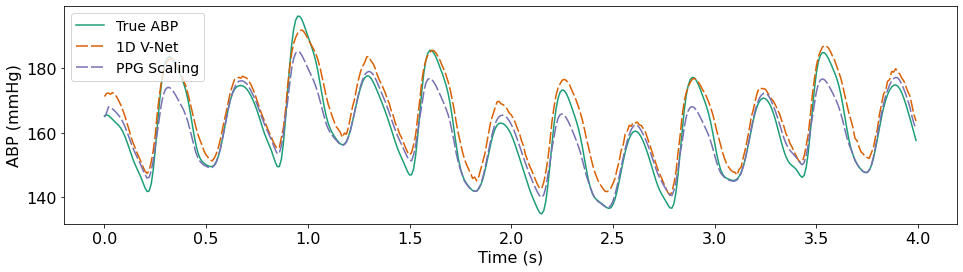

<Figure size 432x288 with 0 Axes>

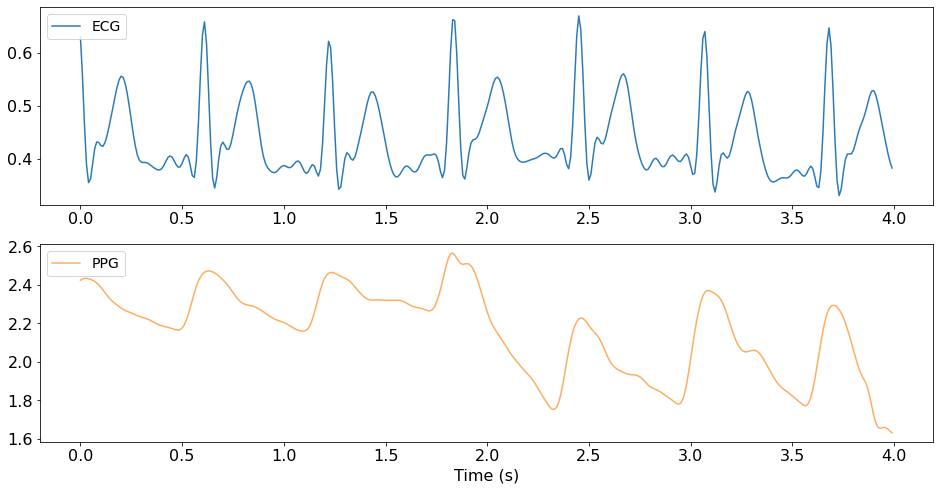

3


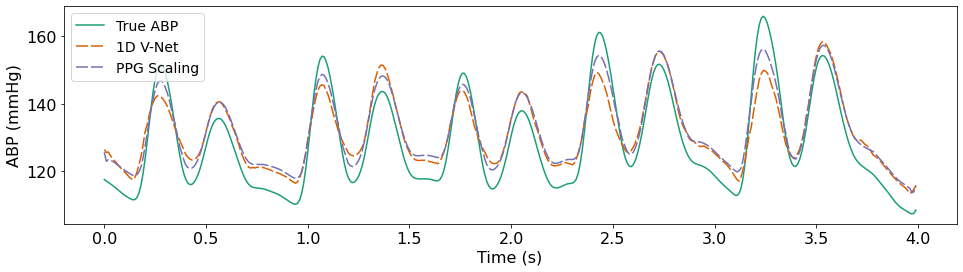

<Figure size 432x288 with 0 Axes>

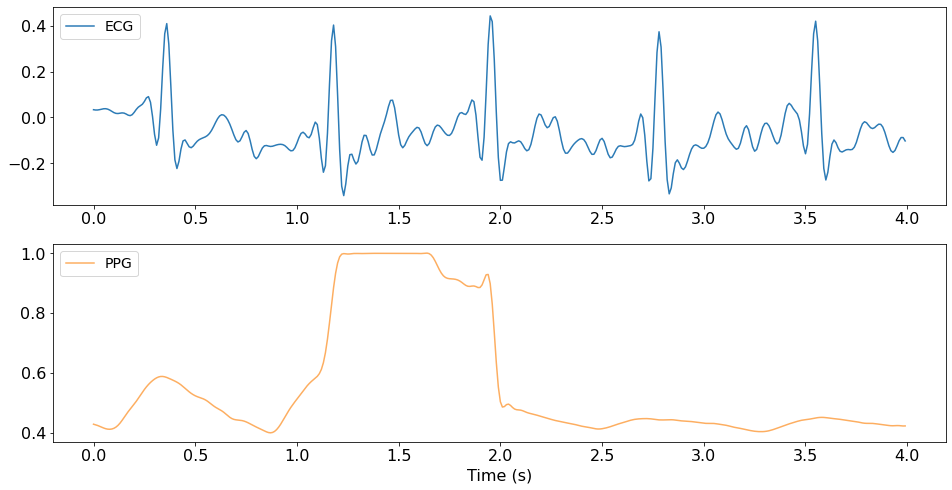

4


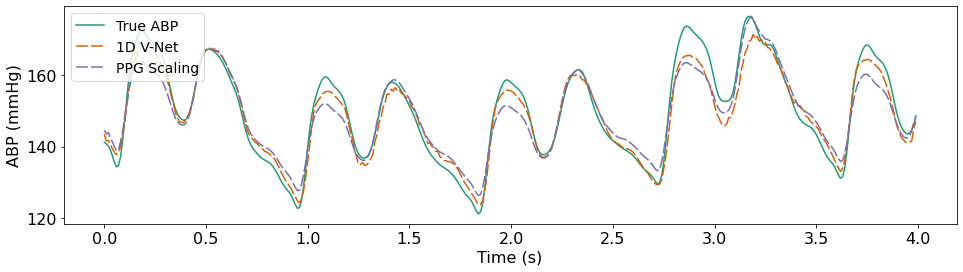

<Figure size 432x288 with 0 Axes>

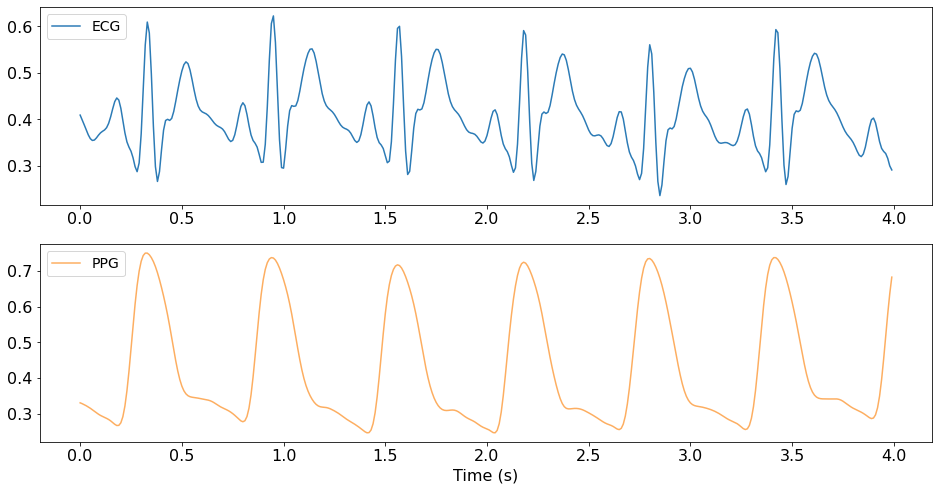

In [110]:
os.makedirs(os.path.join(model_name, "window_figures"), exist_ok=True)
# for i in range(0, 5):
fig_count = 0

for i in np.random.randint(low=0, high=y_true.shape[0], size=5):
    print("="*40)
    print(fig_count)
    print("="*40)
    num_samples_plot = 400
    
    fig, ax  = plt.subplots(1, 1, figsize=(16, 4))
    ax = [ax]
    ax[0].plot(y_true[i][0:num_samples_plot], c='#1b9e77', label="True ABP")
    ax[0].plot(y_pred_nomed[i][0:num_samples_plot], c='#d95f02', label="1D V-Net", dashes=[8, 2])
    ax[0].plot(y_pred[i][0:num_samples_plot], c='#7570b3', label="PPG Scaling", dashes=[8, 2])
    ax[0].legend(loc="upper left", fontsize=project_configs.axis_label_font_size-2)
    xticks = ax[0].get_xticks() / project_configs.sample_freq
    ax[0].set_xticklabels(xticks)
    ax[0].tick_params(axis='both', labelsize=project_configs.axis_tick_label_size)
    ax[0].set_ylabel("ABP (mmHg)", fontsize=project_configs.axis_label_font_size)
    ax[0].set_xlabel("Time (s)", fontsize=project_configs.axis_label_font_size)
    
    plt.savefig(os.path.join(model_name, "window_figures", "Fig_2a_{}.png".format(fig_count)))
    plt.show()
    
    # print(y_true.shape)
    # print(y_pred.shape)
    # fig, ax  = plt.subplots(1, 1, figsize=(16, 4))
    # ax = [ax]
    # ax[0].plot(scale(y_train[i][0:num_samples_plot, 0]), c='#1b9e77', label="Residual: ABP - PPG Scaling", alpha=1.0, dashes=[8, 2])
    # ax[0].plot((y_true[i])[0:num_samples_plot] - (y_pred[i])[0:num_samples_plot], c='#d95f02', label="Residual: ABP - 1D V-Net", alpha=1.0, dashes=[8, 2])
    # ax[0].plot(np.zeros(num_samples_plot), c='black', linestyle=':', label="")
    # ax[0].legend(loc="upper left", fontsize=project_configs.axis_label_font_size-2)
    # ax[0].set_xticklabels(xticks)
    # ax[0].tick_params(axis='both', labelsize=project_configs.axis_tick_label_size)
    # peaks = np.where((y_train[i])[0:num_samples_plot, 1] == 1)
    # print(peaks)
    # ax[0].scatter(peaks, scale(y_train[i][peaks, 0]), c='black', marker="x", label="")
    # ax[0].scatter(peaks, (y_true[i])[peaks] - (y_pred[i])[peaks], c='black', marker="o", label="")
    # ax[0].set_ylabel("ABP (mmHg)", fontsize=project_configs.axis_label_font_size)
    # ax[0].set_xlabel("Time (s)", fontsize=project_configs.axis_label_font_size)
    
#     diffs = np.abs(np.ediff1d(y_true[i]))
#     zeros = np.max(diffs) - diffs
#     zeros = diffs[0:num_samples_plot]
#     ax[1].plot(zeros)
#     extrema = np.where(zeros < 0.1)
#     ax[1].scatter(extrema, zeros[extrema], c='red', marker='.')
#     ax[0].scatter(extrema, y_true[i][extrema], c='red', marker='o')
#     ax[1].plot(X[i, :, project_configs.abp_col] - X_scaled[i])
#     ax[1].plot(residual[i])
    
    plt.savefig(os.path.join(model_name, "window_figures", "Fig_2b_{}.png".format(fig_count)))
    plt.show()
    
    fig, ax  = plt.subplots(2, 1, figsize=(16, 8))
    ax[0].plot(X[i][0:num_samples_plot, project_configs.ecg_col], c='#2c7bb6', label="ECG")
    ax[0].legend(loc="upper left", fontsize=project_configs.axis_label_font_size-2)
    xticks = ax[0].get_xticks() / project_configs.sample_freq
    ax[0].set_xticklabels(xticks)
    ax[0].tick_params(axis='both', labelsize=project_configs.axis_tick_label_size)
#     ax[0].set_ylabel("ABP (mmHg)", fontsize=project_configs.axis_label_font_size)

    ax[1].plot(X[i][0:num_samples_plot, project_configs.ppg_col], c='#fdae61', label="PPG")
    ax[1].legend(loc="upper left", fontsize=project_configs.axis_label_font_size-2)
    xticks = ax[0].get_xticks() / project_configs.sample_freq
    ax[1].set_xticklabels(xticks)
    ax[1].tick_params(axis='both', labelsize=project_configs.axis_tick_label_size)
    ax[1].set_xlabel("Time (s)", fontsize=project_configs.axis_label_font_size)
    
    plt.savefig(os.path.join(model_name, "window_figures", "Fig_1_{}.png".format(fig_count)))
    plt.show()
    
    fig_count += 1

In [ ]:
# pickle.dump(y_true, open(os.path.join(model_name, "{}_y_true.pkl".format(method)), "wb"))
# pickle.dump(y_pred, open(os.path.join(model_name, "{}_y_pred.pkl".format(method)), "wb"))
#pickle.dump(y_pred_med, open(os.path.join(model_name, "{}_y_pred_med.pkl".format(method)), "wb"))

In [ ]:
#y_true = pickle.load(open(os.path.join(model_name, "{}_y_true.pkl".format(method)), "rb"))
y_pred_nomed = pickle.load(open(os.path.join(model_name, "{}_y_pred.pkl".format(method)), "rb"))
#y_pred_med = pickle.load(open(os.path.join(model_name, "{}_y_pred_med.pkl".format(method)), "rb"))

In [111]:
y_avg = ((y_true + y_pred) / 2).mean(axis=1)
y_avg.shape

(218649,)

In [112]:
y_diff = (y_true - y_pred).mean(axis=1)
y_diff.shape

(218649,)

In [113]:
y_ppg_scale_pred = X_scaled
y_diff_ppg = (y_true - y_ppg_scale_pred).mean(axis=1)
y_diff_ppg.shape

(218649,)

nan

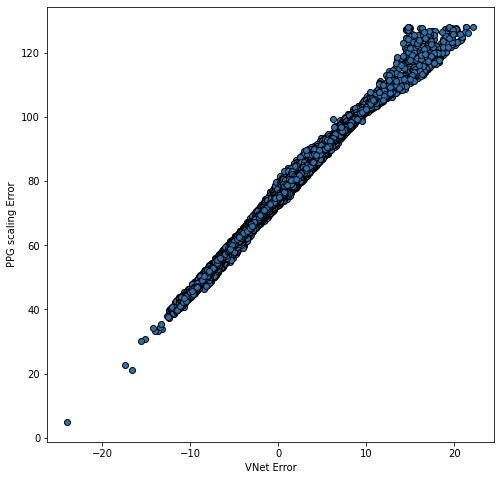

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(y_diff, y_diff_ppg, edgecolors="black")
ax.set_xlabel("VNet Error")
ax.set_ylabel("PPG scaling Error")
np.corrcoef(y_diff, y_diff_ppg)[0, 1]

## Create long waveform plots

  0%|          | 0/1 [00:00<?, ?it/s]

Found 89298 values for p078076-2113-08-13-11-17


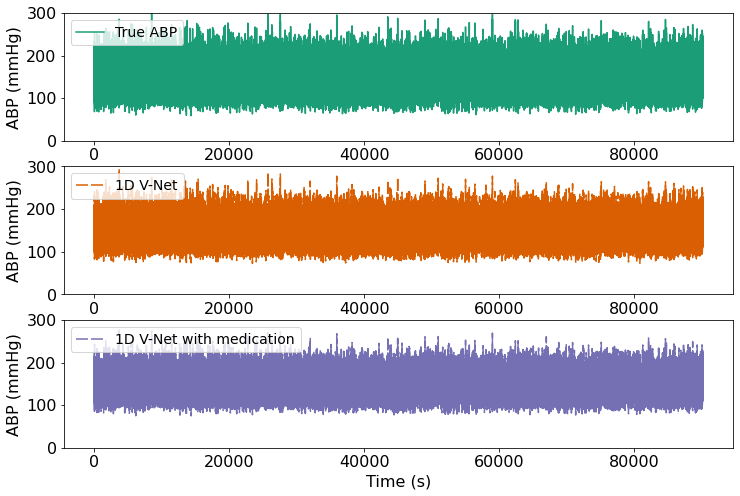

100%|██████████| 1/1 [00:17<00:00, 17.45s/it]


In [115]:
os.makedirs(os.path.join(model_name, "long_waveforms"), exist_ok=True)
# for each patient, calculate Bland-ALtman values
for p in tqdm(np.random.choice(np.unique(patient_label), size=1)):

    indices = np.where(patient_label == p)[0]
    print("Found {} values for {}".format(len(indices), p))
    
    fig, ax = plt.subplots(3, 1, figsize=(12, 8))
    y_true_scaled = []
    y_pred_scaled = []
    y_pred_no_med_scaled = []
    for i in range(22542):
        y_true_scaled.extend(y_true[i])
        y_pred_scaled.extend(y_pred[i])
        y_pred_no_med_scaled.extend(y_pred_nomed[i])
        
    ax[0].plot(y_true_scaled, c='#1b9e77', label="True ABP")
    ax[1].plot(y_pred_no_med_scaled, c='#d95f02', label="1D V-Net", dashes=[8, 2])
    ax[2].plot(y_pred_scaled, c='#7570b3', label="1D V-Net with medication", dashes=[8, 2])
    
    for a in ax:
        a.set_ylim([0, 300])
        a.legend(loc="upper left", fontsize=project_configs.axis_label_font_size-2)
        xticks = [int(x / project_configs.sample_freq) for x in a.get_xticks().tolist()]
        a.set_xticklabels(xticks)
        a.tick_params(axis='both', which='major', labelsize=project_configs.axis_tick_label_size)
#         a.tick_params(axis='both', labelsize=project_configs.axis_tick_label_size)
        a.set_ylabel("ABP (mmHg)", fontsize=project_configs.axis_label_font_size)
        a.set_xlabel("Time (s)", fontsize=project_configs.axis_label_font_size)
        
    plt.savefig(os.path.join(model_name, "long_waveforms", "{}_long_waveform.png".format(p)))
    plt.show()

In [116]:
y_diff.shape

(218649,)

In [117]:
patient_label.shape

(242944,)

## Create joint Bland-Altman plot

In [118]:
def bland_altman_vals(m1, m2):
    means = np.mean([m1, m2], axis=0)
    differences = np.array(m1) - np.array(m2)
    return means, differences

In [119]:
bland_altman_sys = {}
bland_altman_dias = {}


# for each patient, calculate Bland-ALtman values
for p in tqdm(np.unique(patient_label)):

    y_true_sys_bp_all = []
    y_true_dias_bp_all = []
    y_pred_sys_bp_all = []
    y_pred_dias_bp_all = []

    indices = np.where(patient_label == p)[0]
    print("Found {} values for {}".format(len(indices), p))
    
    for i in range(0,10000,3):
        y_true_scaled = y_true[i]
        y_pred_scaled = y_pred[i]

        # get indices of sys/dias BP
        true_bp_max_indices, true_bp_min_indices = get_art_peaks(y_true_scaled)
        pred_bp_max_indices, pred_bp_min_indices = get_art_peaks(y_pred_scaled)

        # align bp indices in case of different number of peaks
        true_bp_max_indices, pred_bp_max_indices = align_lists(true_bp_max_indices, pred_bp_max_indices)
        true_bp_min_indices, pred_bp_min_indices = align_lists(true_bp_min_indices, pred_bp_min_indices)

        # get values of blood pressure at peak indices
        y_true_sys_bp_all = y_true_sys_bp_all + list(y_true_scaled[true_bp_max_indices])
        y_true_dias_bp_all = y_true_dias_bp_all + list(y_true_scaled[true_bp_min_indices])

        y_pred_sys_bp_all = y_pred_sys_bp_all + list(y_pred_scaled[pred_bp_max_indices])
        y_pred_dias_bp_all = y_pred_dias_bp_all + list(y_pred_scaled[pred_bp_min_indices])

    # save data for plotting bland-altman for all patients
        bland_altman_sys[i] = bland_altman_vals(y_true_sys_bp_all, y_pred_sys_bp_all)
        bland_altman_dias[i] = bland_altman_vals(y_true_dias_bp_all, y_pred_dias_bp_all)

  0%|          | 0/8 [00:00<?, ?it/s]

Found 32364 values for p029961-2115-06-25-10-57


  0%|          | 0/8 [00:25<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
pickle.dump(bland_altman_sys, open(os.path.join(model_name, "{}_bland_altman_sys.pkl".format(method)), "wb"))
pickle.dump(bland_altman_dias, open(os.path.join(model_name, "{}_bland_altman_dias.pkl".format(method)), "wb"))

In [ ]:
bland_altman_sys = pickle.load(open(os.path.join(model_name, "{}_bland_altman_sys.pkl".format(method)), "rb"))
bland_altman_dias = pickle.load(open(os.path.join(model_name, "{}_bland_altman_dias.pkl".format(method)), "rb"))

In [ ]:
# plot bland-altman for all patients, where x-value is mean of the average, y-value is mean of
# differences (errors), x-error-bar is std. dev. of average, and y-error-bar is std. dev. of the
# differences (errors
print(len(bland_altman_sys.values()))
x_sys = [np.mean(m[0]) for m in bland_altman_sys.values()]
y_sys = [np.mean(m[1]) for m in bland_altman_sys.values()]
x_error_sys = [np.std(m[0]) for m in bland_altman_sys.values()]
y_error_sys = [np.std(m[1]) for m in bland_altman_sys.values()]

x_dias = [np.mean(m[0]) for m in bland_altman_dias.values()]
y_dias = [np.mean(m[1]) for m in bland_altman_dias.values()]
x_error_dias = [np.std(m[0]) for m in bland_altman_dias.values()]
y_error_dias = [np.std(m[1]) for m in bland_altman_dias.values()]

# draw lines on plot for mean, SD, 2xSD
sys_diffs = [i for sublist in [m[1] for m in bland_altman_sys.values()] for i in sublist]

mean_sys_diff_all = np.mean(sys_diffs)
std_sys_diff_all = np.std(sys_diffs)
print("Mean diff Sys BP: {} (+/- {})".format(mean_sys_diff_all, std_sys_diff_all))
print("Mean Absolute diff Sys BP: {} (+/- {})".format(np.mean(np.abs(sys_diffs)), np.std(np.abs(sys_diffs))))

population_rmse_sys = [np.sqrt(np.mean(np.square(m[1]))) for m in bland_altman_sys.values()]
print("RMSE diff Sys BP: {} (+/- {})".format(np.mean(population_rmse_sys), np.std(population_rmse_sys)))

dias_diffs = [i for sublist in [m[1] for m in bland_altman_dias.values()] for i in sublist]

mean_dias_diff_all = np.mean(dias_diffs)
std_dias_diff_all = np.std(dias_diffs)
print("Mean diff Dias BP: {} (+/- {})".format(mean_dias_diff_all, std_dias_diff_all))
print("Mean Absolute diff Dias BP: {} (+/- {})".format(np.mean(np.abs(dias_diffs)), np.std(np.abs(dias_diffs))))

population_rmse_dias = [np.sqrt(np.mean(np.square(m[1]))) for m in bland_altman_dias.values()]
print("RMSE diff Dias BP: {} (+/- {})".format(np.mean(population_rmse_dias), np.std(population_rmse_dias)))

plot_lim = [-60, 60]
sys_axis_lim = [50, 300]
dias_axis_lim = [0, 150]
axis_label_font_size = 14
title_font_size = 16
title_string = "Bland-Altman {} ABP - Test: {:.2f} +/- {:.2f}"
line_limits = [1, 2]
dashes = [[20, 5], [10, 2]]


fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_ylim(plot_lim)
ax[0].set_xlim(sys_axis_lim)
ax[0].set_yticks(np.arange(plot_lim[0], plot_lim[1] + 1, 15))
ax[0].set_xticks(np.arange(sys_axis_lim[0], sys_axis_lim[1] + 1, 25))
ax[0].tick_params(labelsize=13)
ax[0].errorbar(x_sys, y_sys, xerr=x_error_sys, yerr=y_error_sys, fmt='o', markeredgecolor='black',
               ecolor='g', capthick=2, capsize=2)
ax[0].set_ylabel("Invasive - Predicted Arterial Pressure [mmHg]", fontsize=axis_label_font_size)
ax[0].set_xlabel("(Invasive + Predicted Arterial Pressure)/2 [mmHg]", fontsize=axis_label_font_size)
# add number of points to plot
ax[0].legend(["N={}".format(len(bland_altman_sys))], loc='upper left')
# add title
ax[0].set_title(title_string.format("Systolic",
                                    np.round(mean_sys_diff_all, 3),
                                    np.round(std_sys_diff_all, 3)), fontsize=title_font_size)
# add SD lines
ax[0].axhline(mean_sys_diff_all, linestyle='-', c='black')
for sd_limit, dash_style in zip(line_limits, dashes):
    limit_of_agreement = sd_limit * std_sys_diff_all
    lower = mean_sys_diff_all - limit_of_agreement
    upper = mean_sys_diff_all + limit_of_agreement
    for j, lim in enumerate([lower, upper]):
        ax[0].axhline(lim, linestyle='--', dashes=dash_style, c='black')


ax[1].set_ylim(plot_lim)
ax[1].set_xlim(dias_axis_lim)
ax[1].set_yticks(np.arange(plot_lim[0], plot_lim[1] + 1, 15))
ax[1].set_xticks(np.arange(dias_axis_lim[0], dias_axis_lim[1] + 1, 25))
ax[1].tick_params(labelsize=13)
ax[1].errorbar(x_dias, y_dias, xerr=x_error_dias, yerr=y_error_dias, fmt='o', markeredgecolor='black',
               ecolor='g', capthick=2, capsize=2)
ax[1].set_ylabel("Invasive - Predicted Arterial Pressure [mmHg]", fontsize=axis_label_font_size)
ax[1].set_xlabel("(Invasive + Predicted Arterial Pressure)/2 [mmHg]", fontsize=axis_label_font_size)
# add number of points to plot
ax[1].legend(["N={}".format(len(bland_altman_dias))], loc='upper left')
# add title
ax[1].set_title(title_string.format("Diastolic",
                                    np.round(mean_dias_diff_all, 3),
                                    np.round(std_dias_diff_all, 3)), fontsize=title_font_size)
ax[1].axhline(mean_dias_diff_all, linestyle='-', c='black')
for sd_limit, dash_style in zip(line_limits, dashes):
    limit_of_agreement = sd_limit * std_dias_diff_all
    lower = mean_dias_diff_all - limit_of_agreement
    upper = mean_dias_diff_all + limit_of_agreement
    for j, lim in enumerate([lower, upper]):
        ax[1].axhline(lim, linestyle='--', dashes=dash_style, c='black')
plt.savefig(os.path.join(model_name, "{}_joint_bland_altman.png".format(method)))
plt.show()
plt.close()

In [120]:
print(y_diff.mean(), y_diff.std())

nan nan


In [122]:
result_string = "{:.3f} ({:.3f}-{:.3f})"
wave_level_metrics = {}

In [123]:
def ci(values, alpha=0.95):
    # if we get lower value, flip
    if alpha < 0.5:
        alpha = 1. - alpha
    interp = "lower"
    return np.quantile(values, 1.-alpha, interpolation=interp), np.quantile(values, alpha, interpolation=interp)

def bootstrap(values, num_bootstrap, function):
    bootstrap_res = []
    values = np.array(values)
    for _ in tqdm(range(num_bootstrap)):
        bootstrap_idx = np.random.choice(np.arange(len(values)), size=len(values), replace=True)
        bootstrap_res.append(function(values[bootstrap_idx]))
    lower, upper = ci(bootstrap_res)
    return np.mean(bootstrap_res), lower, upper

In [124]:
sys_bootstrap_mean = bootstrap(sys_diffs, 10, function=np.mean)
sys_bootstrap_mean

100%|██████████| 10/10 [00:00<00:00, 2557.19it/s]
/tmp/ipykernel_3472564/766180371.py:6: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  return np.quantile(values, 1.-alpha, interpolation=interp), np.quantile(values, alpha, interpolation=interp)


(5.302499880978771, 5.190201952015884, 5.363169539675489)

In [125]:
num_bootstrap_iter = 1000
sys_bootstrap_mean = bootstrap(sys_diffs, num_bootstrap=num_bootstrap_iter, function=np.mean)
dias_bootstrap_mean = bootstrap(dias_diffs, num_bootstrap=num_bootstrap_iter, function=np.mean)
wave_level_metrics["sys_bootstrap_mean"] = result_string.format(*sys_bootstrap_mean)
wave_level_metrics["dias_bootstrap_mean"] = result_string.format(*dias_bootstrap_mean)
wave_level_metrics

100%|██████████| 1000/1000 [00:00<00:00, 2124.41it/s]
/tmp/ipykernel_3472564/766180371.py:6: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  return np.quantile(values, 1.-alpha, interpolation=interp), np.quantile(values, alpha, interpolation=interp)
100%|██████████| 1000/1000 [00:00<00:00, 4064.62it/s]


{'sys_bootstrap_mean': '5.307 (5.195-5.410)',
 'dias_bootstrap_mean': '-3.216 (-3.292--3.141)'}

In [126]:
sys_bootstrap_std = bootstrap(sys_diffs, num_bootstrap=num_bootstrap_iter, function=np.std)
dias_bootstrap_std = bootstrap(dias_diffs, num_bootstrap=num_bootstrap_iter, function=np.std)
wave_level_metrics["sys_bootstrap_std"] = result_string.format(*sys_bootstrap_std)
wave_level_metrics["dias_bootstrap_std"] = result_string.format(*dias_bootstrap_std)
wave_level_metrics

100%|██████████| 1000/1000 [00:00<00:00, 1621.33it/s]
/tmp/ipykernel_3472564/766180371.py:6: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  return np.quantile(values, 1.-alpha, interpolation=interp), np.quantile(values, alpha, interpolation=interp)
100%|██████████| 1000/1000 [00:00<00:00, 1690.23it/s]


{'sys_bootstrap_mean': '5.307 (5.195-5.410)',
 'dias_bootstrap_mean': '-3.216 (-3.292--3.141)',
 'sys_bootstrap_std': '7.500 (7.413-7.589)',
 'dias_bootstrap_std': '5.146 (5.024-5.276)'}

In [127]:
rmse = np.sqrt(np.square(y_true - y_pred).mean(axis=1))
print(rmse.shape)
print(rmse.mean(), rmse.std())
rmse_bootstrap = bs.bootstrap(rmse, stat_func=bs_stats.mean)
print(rmse_bootstrap)
wave_level_metrics["rmse"] = result_string.format(rmse_bootstrap.value, rmse_bootstrap.lower_bound, rmse_bootstrap.upper_bound)

(218649,)
nan nan


KeyboardInterrupt: 

In [ ]:
corr = []
for i in range(y_true.shape[0]):
    corr.append(np.corrcoef(y_true[i], y_pred[i])[0, 1])
corr = np.array(corr)
print(corr.shape)
print(corr[~np.isnan(corr)].mean(), corr[~np.isnan(corr)].std())

corr_bootstrap = bs.bootstrap(corr[~np.isnan(corr)], stat_func=bs_stats.mean)
print(corr_bootstrap)
wave_level_metrics["corr"] = result_string.format(corr_bootstrap.value, corr_bootstrap.lower_bound, corr_bootstrap.upper_bound)

In [ ]:
pd.DataFrame.from_dict(wave_level_metrics, orient="index", columns=["metric"]).to_csv(os.path.join(model_name, "{}_wave_metrics.csv".format(method)), index=True, header=True)

In [ ]:
samp = np.random.normal(loc=0.0, scale=6.0, size=10000)
print(samp.mean())
print(samp.std())
for i in range(40):
    samp[i] = 40
print(samp.mean())
print(samp.std())

In [ ]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.010

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(y_avg, y_diff, edgecolors= "black")

# now determine nice limits by hand:
binwidth = 0.25
lim = np.ceil(np.abs([y_avg, y_diff]).max() / binwidth) * binwidth
ax_scatter.set_xlim((0, 150))
ax_scatter.set_ylim((-65, 65))

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(y_avg, bins=bins)
ax_histy.hist(y_diff, bins=bins, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

In [ ]:
bad_idx = np.arange(0, len(y_true))[(y_diff < 100) & (y_diff > 30) & (np.abs(X_train[:, :, project_configs.nibp_mean_col].mean(axis=1) - X_train[:, :, project_configs.abp_col].mean(axis=1)) <= 100)]
print(bad_idx.shape)

In [ ]:
# num_coeffs = 32

# for i in bad_idx:
#     print("="*40)
#     print(i)
#     fig, ax = plt.subplots(1, 1, figsize=(24, 4))
#     plt.plot(y_true[i], c='green')
#     plt.plot(y_pred[i], c='red')
#     print("error:", y_diff[i])
#     print("ediff zero count:", np.count_nonzero(np.ediff1d(y_true[i])==0.0))
#     print("sys:", np.median(X_train[i][:, project_configs.nibp_sys_col]))
#     print("dias:", np.median(X_train[i][:, project_configs.nibp_dias_col]))
#     print("TFC:", np.median(X_train[i][:, project_configs.prox_col])/project_configs.sample_freq)
#     print("hr:", np.median(X_train[i][:, 6]*wave_feats_std[0]+wave_feats_median[0]))
#     print("ptt:", np.exp(np.median(X_train[i][:, 7]*wave_feats_std[1]+wave_feats_median[1])))
#     print("ptt var:", np.median(X_train[i][:, 8]*wave_feats_std[2]+wave_feats_median[2]))
#     print("PPG QI:", ppg_qi_preds[valid_window_idx][i])
#     pulse_pressure = np.max(y_true[i])-np.min(y_true[i])
#     print("ABP Pulse pressure:", pulse_pressure)
#     ppg_pp = np.max(X_train[i][:, project_configs.ppg_col])-np.min(X_train[i][:, project_configs.ppg_col])
#     print("PPG pulse pressure:", ppg_pp)
#     print("ABP/PPG PP ratio:", pulse_pressure/ppg_pp)
#     plt.show()
    
#     Q = np.fft.rfft(y_true[i]).real[1:num_coeffs].reshape(-1, 1)
# #     R = np.fft.rfft(y_pred[i]).real[1:num_coeffs].reshape(-1, 1)
#     plt.plot(Q)
# #     plt.plot(R)
#     plt.show()
    
#     fig, ax = plt.subplots(1, 1, figsize=(24, 4))
#     plt.plot(y_true[i][0:800], c='green')
#     plt.plot(y_ppg_scale_pred[i][0:800], c='red')
#     plt.show()
    
#     fig, ax = plt.subplots(1, 1, figsize=(16, 4))
#     plt.plot(X_train[i][:800, project_configs.ppg_col])
#     plt.show()
    
#     fig, ax = plt.subplots(1, 1, figsize=(32, 4))
#     plt.plot(X_train[i][:800, project_configs.ecg_col])
#     plt.show()

In [ ]:
# look at outlier ABP pulse pressure windows

# look at outlier PPG pulse pressure windows

# look at outlier ABP PP/PPG PP windows

# see how to automatically determine underdampening (might be a frequency outlier?)

In [129]:
bad_bp_wins = []
for i in range(X_train.shape[0]):
    diff_bp = np.max(y_true[i]) - np.median(X_train[i, :, project_configs.nibp_sys_col])
    bad_bp_wins.append(diff_bp)

bad_bp_wins = np.array(bad_bp_wins)

In [ ]:
# for i in np.where(bad_bp_wins > 40)[0]:
#     print("="*40)
#     print("Drift:", bad_bp_wins[i])
#     print("Time:", np.median(X_train[i, :, project_configs.prox_col])/project_configs.sample_freq)
#     fig, ax = plt.subplots(1, 1, figsize=(16,4))
#     plt.plot(y_true[i], c='green')
#     plt.show()
#     fig, ax = plt.subplots(1, 1, figsize=(16,4))
#     plt.plot(y_true[i][0:800], c='green')
#     plt.show()

In [130]:
abp_pp_all = []
ppg_pp_all = []
for i in range(X_train.shape[0]):
    abp_pp = np.max(y_true[i])-np.min(y_true[i])
    abp_pp_all.append(abp_pp)
    ppg_pp = np.max(X_train[i][:, project_configs.ppg_col])-np.min(X_train[i][:, project_configs.ppg_col])
    ppg_pp_all.append(ppg_pp)

(array([2.4000e+01, 6.0000e+01, 8.5000e+01, 1.1100e+02, 9.9000e+01,
        1.0400e+02, 1.0700e+02, 1.1200e+02, 1.0300e+02, 1.1700e+02,
        1.4600e+02, 1.7300e+02, 2.1400e+02, 3.6300e+02, 4.4400e+02,
        6.5300e+02, 8.1400e+02, 1.0760e+03, 1.3270e+03, 1.6990e+03,
        2.1870e+03, 2.7630e+03, 3.5120e+03, 4.4230e+03, 5.3220e+03,
        6.2360e+03, 7.3210e+03, 8.0220e+03, 8.7180e+03, 9.1810e+03,
        9.6020e+03, 1.0105e+04, 1.0156e+04, 1.0012e+04, 9.5700e+03,
        9.1500e+03, 8.7770e+03, 8.2060e+03, 7.4760e+03, 6.7060e+03,
        6.2080e+03, 5.7160e+03, 5.1390e+03, 4.7100e+03, 4.2680e+03,
        3.7950e+03, 3.4860e+03, 3.1530e+03, 2.7380e+03, 2.5520e+03,
        2.2100e+03, 2.0300e+03, 1.7000e+03, 1.5280e+03, 1.4230e+03,
        1.2910e+03, 1.1380e+03, 9.3900e+02, 9.0600e+02, 8.3400e+02,
        6.8600e+02, 6.5400e+02, 5.5000e+02, 4.9000e+02, 4.9900e+02,
        4.4500e+02, 4.0200e+02, 3.7900e+02, 3.5300e+02, 3.0300e+02,
        2.6700e+02, 2.5300e+02, 2.5600e+02, 2.29

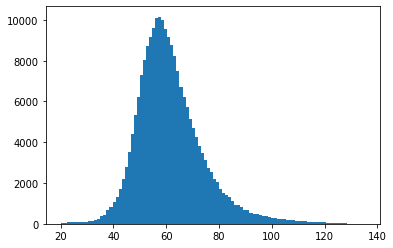

In [131]:
plt.hist(abp_pp_all, bins=100)

(array([6.7900e+02, 1.1500e+02, 3.2800e+02, 8.8600e+02, 3.4920e+03,
        2.9380e+03, 2.0570e+03, 1.7870e+03, 2.1140e+03, 2.6510e+03,
        4.6460e+03, 3.0932e+04, 1.7136e+04, 6.9480e+03, 4.0010e+03,
        3.0620e+03, 2.7470e+03, 2.9410e+03, 2.6330e+03, 2.3760e+03,
        2.3280e+03, 2.1860e+03, 2.4990e+03, 2.2260e+03, 1.9260e+03,
        1.9570e+03, 1.9990e+03, 2.1190e+03, 2.2440e+03, 2.2120e+03,
        2.2480e+03, 2.3270e+03, 2.3350e+03, 2.4360e+03, 2.4880e+03,
        2.3920e+03, 2.4560e+03, 2.4820e+03, 2.5280e+03, 2.5200e+03,
        2.6040e+03, 2.7390e+03, 2.9260e+03, 3.5450e+03, 4.6990e+03,
        5.8190e+03, 5.6060e+03, 5.2880e+03, 4.9830e+03, 4.5750e+03,
        4.1150e+03, 3.8340e+03, 3.7470e+03, 3.4360e+03, 2.9710e+03,
        2.6400e+03, 2.0780e+03, 1.7690e+03, 1.4530e+03, 1.1340e+03,
        9.3200e+02, 7.8200e+02, 6.3600e+02, 5.7200e+02, 5.0100e+02,
        4.3800e+02, 4.2300e+02, 4.0900e+02, 4.2100e+02, 3.5700e+02,
        2.8200e+02, 2.3100e+02, 2.0600e+02, 1.50

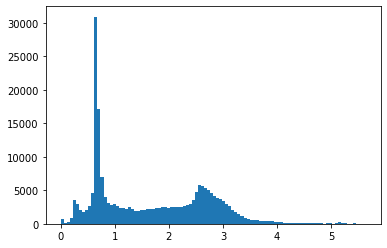

In [132]:
plt.hist(ppg_pp_all, bins=100)

In [ ]:
plt.hist(np.array(abp_pp_all)/np.array(ppg_pp_all), bins=100)

nan

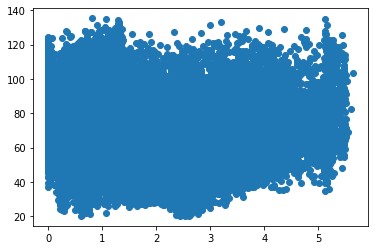

In [134]:
plt.scatter(ppg_pp_all, abp_pp_all)
np.corrcoef(ppg_pp_all, abp_pp_all)[0, 1]

In [135]:
# bw = np.where(np.abs(X[:, :, project_configs.nibp_mean_col].mean(axis=1) - X[:, :, project_configs.abp_col].mean(axis=1)) <= 10)[0]
# bw = np.where(X[:, :, project_configs.prox_col].mean(axis=1) <= 300*project_configs.sample_freq)[0]
bw = (X[:, :, project_configs.prox_col].mean(axis=1) <= 300*project_configs.sample_freq) & (X[:, :, project_configs.prox_col].mean(axis=1) >= 270*project_configs.sample_freq)
print(bw.shape)

(242944,)


In [ ]:
get_beats(y_true[bw], y_pred[bw])

In [ ]:
# look at the distribution of the difference between the previous mean NIBP measurement and the current mean ABP measurement 
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nibp_abp_diffs = X[:, :, project_configs.abp_col].mean(axis=1) - X[:, :, project_configs.nibp_mean_col].mean(axis=1)
ax.hist(nibp_abp_diffs, bins=100)
ax.set_title("Difference between previous mean NIBP and current mean ABP ({:.2f} +/- {:.2f})".format(
    np.mean(nibp_abp_diffs), 
    np.std(nibp_abp_diffs)))
ax.set_ylabel("Number of windows")
ax.set_xlabel("Difference (mmHg)")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(nibp_abp_diffs, y_diff, edgecolors="black")
ax.set_xlabel("Current ABP - Previous NIBP")
ax.set_ylabel("True ABP - Predicted ABP")
np.corrcoef(nibp_abp_diffs, y_diff)[0, 1]

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# ax.scatter(ppg_qi_preds[(valid_window_idx) & valid_samples_from_cuff], y_diff, edgecolors="black")
# ax.set_xlabel("PPG QI")
# ax.set_ylabel("True ABP - Predicted ABP")
# np.corrcoef(nibp_abp_diffs, y_diff_ppg)[0, 1]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(nibp_abp_diffs, y_diff_ppg, edgecolors="black")
ax.set_xlabel("Current ABP - Previous NIBP")
ax.set_ylabel("True ABP - Predicted ABP")
np.corrcoef(nibp_abp_diffs, y_diff_ppg)[0, 1]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(nibp_abp_diffs, np.abs(y_diff-y_diff_ppg), edgecolors="black")
ax.set_xlabel("Current ABP - Previous NIBP")
ax.set_ylabel("VNet Error - PPG Scaling Error")
np.corrcoef(nibp_abp_diffs, np.abs(y_diff-y_diff_ppg))[0, 1]

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# ax.scatter(time_from_cuff[valid_samples_from_cuff], y_diff-y_diff_ppg, edgecolors="black")
# ax.set_xlabel("Time since NIBP measurement (s)")
# ax.set_ylabel("True ABP - Predicted ABP")
# np.corrcoef(time_from_cuff[valid_samples_from_cuff], y_diff-y_diff_ppg)[0, 1]

In [ ]:
time_from_cuff = X[:, :, project_configs.prox_col].mean(axis=1) / project_configs.sample_freq

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(time_from_cuff, y_diff, edgecolors="black")
# ax.scatter(time_from_cuff[valid_samples_from_cuff], y_diff, edgecolors="black")
ax.set_xlabel("Time since NIBP measurement (s)")
ax.set_ylabel("True ABP - Predicted ABP")
np.corrcoef(time_from_cuff, y_diff)[0, 1]
# np.corrcoef(time_from_cuff[valid_samples_from_cuff], y_diff)[0, 1]
# results_df_filtered = pd.DataFrame.from_dict({"time": time_from_cuff[valid_samples_from_cuff], "error": y_diff, "rmse": rmse}, orient="columns")
results_df_filtered = pd.DataFrame.from_dict({"time": time_from_cuff, "error": y_diff, "rmse": rmse}, orient="columns")
results_df_filtered.to_csv(os.path.join(model_name, "{}_time_vs_error.csv.gz".format(method)), header=True, index=False)

In [ ]:
def wave_rmse_mean_std(window):
    """
    For calculating error distribution for each bin of times from most recent NIBP measurement
    :param window: pandas DataFrame with true and predicted waveforms for each patient
    :return: pandas Series with mean of RMSE and std of RMSE over all patients
    """
    if window.shape[0] > 0:
        mean_rmse = window["rmse"].mean()
        std_rmse = window["rmse"].std()
        return pd.Series({'mean_rmse': mean_rmse, 'std_rmse': std_rmse})
    else:
        return pd.Series({'mean_rmse': np.nan, 'std_rmse': np.nan})

In [ ]:
max_time_from_nibp = 100 * 60 * 5
# bin_width is number of seconds per bin
bin_width = 10
bins = range(0, int(max_time_from_nibp / project_configs.sample_freq)+1, bin_width)
grouped_df = results_df_filtered.groupby(pd.cut(results_df_filtered["time"], bins=bins)).apply(wave_rmse_mean_std)
grouped_df.to_csv(os.path.join(model_name, "{}_error_vs_time_from_cuff.csv".format(method)), header=True, index=True)

In [ ]:
grouped_df

In [ ]:
def error_vs_time_from_cuff(grouped_df, save_dir):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    grouped_df["mean_rmse"].plot(ax=ax)
    ax.fill_between(np.arange(len(grouped_df["std_rmse"].values)),
                    (grouped_df["mean_rmse"] - grouped_df["std_rmse"]).values,
                    (grouped_df["mean_rmse"] + grouped_df["std_rmse"]).values,
                    alpha=0.2)

    # plt.xticks(rotation=45)
#     plt.locator_params(axis='x', nbins=4)
    ax.tick_params(labelsize=project_configs.axis_tick_label_size)
    plt.xlabel("Time from most recent NIBP measurement (seconds)", fontsize=project_configs.axis_label_font_size)
    plt.ylabel("RMSE", fontsize=project_configs.axis_label_font_size)
    plt.ylim([0, 80])
    plt.xticks(ticks=np.arange(grouped_df.shape[0])[::6], labels=grouped_df.index[::6])
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "error_vs_time_from_cuff.png"))
    plt.show()

In [ ]:
error_vs_time_from_cuff(grouped_df, save_dir=model_name)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(time_from_cuff[valid_samples_from_cuff], nibp_abp_diffs, edgecolors="black")
ax.set_xlabel("Time since NIBP measurement (s)")
ax.set_ylabel("Current ABP - Previous NIBP")
np.corrcoef(time_from_cuff[valid_samples_from_cuff], nibp_abp_diffs)[0, 1]